In [5]:
import scipy.io as scio
import matplotlib.pyplot as plt

data = scio.loadmat('C:/Users/Brilliant/Desktop/data.mat')

matrix_data = data['data']

print(f"\nType of 'data':", type(matrix_data))
print(f"Shape of 'data':", matrix_data.shape)


Type of 'data': <class 'numpy.ndarray'>
Shape of 'data': (16, 604700)


In [6]:
data = scio.loadmat('C:/Users/Brilliant/Desktop/data.mat')
matrix_data = data['data']
# 提取第一行（第一通道的EEG数据）
first_channel = matrix_data[0, :]
sampled_data = first_channel[:50000:10]
len(sampled_data)

5000

In [7]:
len(sampled_data)

5000

## 1

Training progress: 100%|█████████████████████████████████████████████████████████████| 200/200 [06:54<00:00,  2.07s/it]


均方根误差 (RMSE): 8.2524


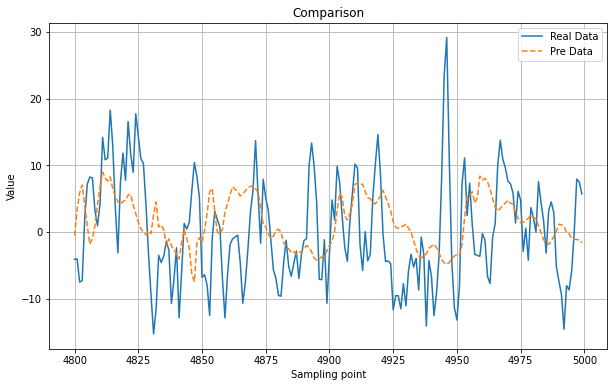

频谱相似度: 0.6360


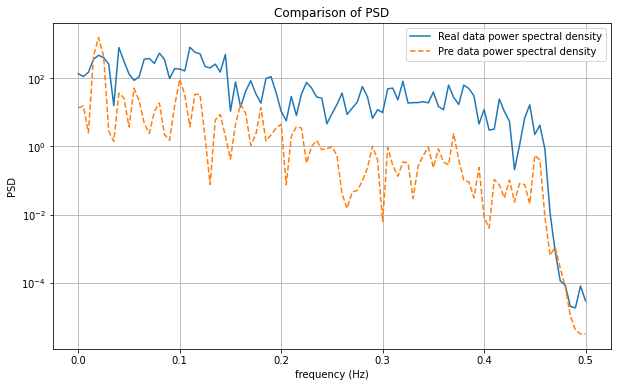

功率谱密度 (PSD) 相似度: 0.3552


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from scipy.fft import fft
from scipy.signal import welch  # 用于计算功率谱密度
from tqdm import tqdm
from tensorflow.keras.callbacks import LambdaCallback

# 假设已经有 sampled_data 变量包含了 5000 个点的数据
# 数据划分
sampled_data = sampled_data[:5000]  # 已经采样好的5000个点
train_data = sampled_data[:4800]  # 前4800个点作为训练数据
test_data = sampled_data[4800:]  # 后200个点作为测试数据

n_steps = 50  # 时间步长
X = []
y = []

# 构建 LSTM 输入，滑动窗口构造样本
for i in range(len(train_data) - n_steps):
    X.append(train_data[i:i+n_steps])
    y.append(train_data[i+n_steps])

X, y = np.array(X), np.array(y)

# 构建 LSTM 模型
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 使用 tqdm 进度条
epochs = 200
with tqdm(total=epochs, desc="Training progress") as pbar:

    def on_epoch_end(epoch, logs):
        pbar.update(1)

    # 创建 LambdaCallback，来在每个 epoch 结束时更新进度条
    progress_callback = LambdaCallback(on_epoch_end=on_epoch_end)

    # 模型训练
    X = X.reshape((X.shape[0], X.shape[1], 1))  # 调整为 LSTM 输入格式
    model.fit(X, y, epochs=epochs, verbose=0, callbacks=[progress_callback])

# 用模型预测未来 200 个点
X_input = train_data[-n_steps:].reshape((1, n_steps, 1))  # 取最后 50 个点作为输入
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)
    predicted_points.append(predicted[0][0])
    
    # 调整 predicted 的形状，使其成为与 X_input 兼容的三维数组
    predicted_reshaped = np.array(predicted).reshape((1, 1, 1))
    
    # 使用 np.append 进行滑动窗口更新
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)  # 滑动窗口

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mean_squared_error(test_data, predicted_points))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制预测结果与真实数据的对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data, label='Real Data')
plt.plot(range(4800, 5000), predicted_points, label='Pre Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
# 对真实值和预测值做 FFT 变换
fft_real = fft(test_data)
fft_pred = fft(predicted_points)

# 计算余弦相似度
fft_real_abs = np.abs(fft_real).reshape(1, -1)
fft_pred_abs = np.abs(fft_pred).reshape(1, -1)
similarity = cosine_similarity(fft_real_abs, fft_pred_abs)

print(f'频谱相似度: {similarity[0][0]:.4f}')

# 计算功率谱密度 (PSD) 用于频域特征匹配
f_real, psd_real = welch(test_data, fs=1.0, nperseg=200)  # Welch 方法计算真实数据的功率谱密度
f_pred, psd_pred = welch(predicted_points, fs=1.0, nperseg=200)  # 计算预测数据的功率谱密度

# 绘制功率谱密度对比图
plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real data power spectral density')
plt.semilogy(f_pred, psd_pred, label='Pre data power spectral density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算频域特征匹配度 (余弦相似度)
psd_real = psd_real.reshape(1, -1)
psd_pred = psd_pred.reshape(1, -1)
psd_similarity = cosine_similarity(psd_real, psd_pred)[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')

## 2

Training Progress: 100%|█████████████████████████████████████████████████████████████| 200/200 [06:50<00:00,  2.05s/it]


均方根误差 (RMSE): 9.8838


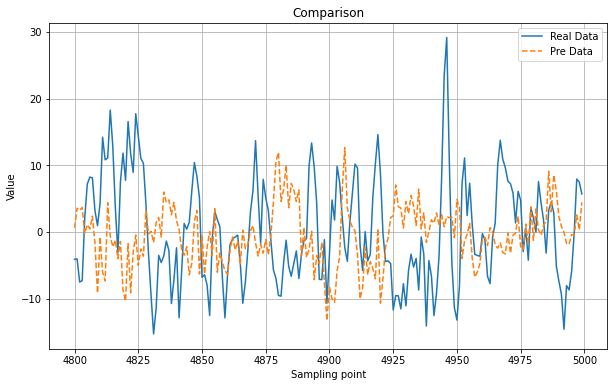

频谱相似度: 0.8199


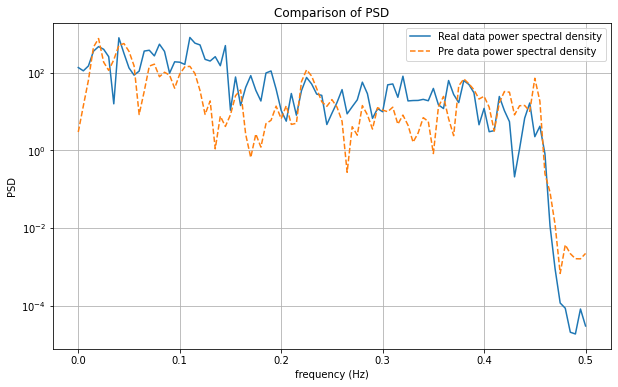

功率谱密度 (PSD) 相似度: 0.6557


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from scipy.fft import fft
from scipy.signal import welch  # 用于计算功率谱密度
from tqdm import tqdm
from tensorflow.keras.callbacks import LambdaCallback

# 假设已经有 sampled_data 变量包含了 5000 个点的数据
# 数据划分
sampled_data = sampled_data[:5000]  # 已经采样好的5000个点
train_data = sampled_data[:4800]  # 前4800个点作为训练数据
test_data = sampled_data[4800:]  # 后200个点作为测试数据

n_steps = 50  # 时间步长
X = []
y = []

# 构建 LSTM 输入，滑动窗口构造样本
for i in range(len(train_data) - n_steps):
    X.append(train_data[i:i+n_steps])
    y.append(train_data[i+n_steps])

X, y = np.array(X), np.array(y)

# 构建 LSTM 模型
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, 1)))  # 输入形状为 (时间步长, 特征数)
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 使用 tqdm 进度条
epochs = 200
with tqdm(total=epochs, desc="Training Progress") as pbar:

    def on_epoch_end(epoch, logs):
        pbar.update(1)

    # 创建 LambdaCallback，来在每个 epoch 结束时更新进度条
    progress_callback = LambdaCallback(on_epoch_end=on_epoch_end)

    # 模型训练
    X = X.reshape((X.shape[0], X.shape[1], 1))  # 调整为 LSTM 输入格式
    model.fit(X, y, epochs=epochs, verbose=0, callbacks=[progress_callback])

# 用模型预测未来 200 个点
X_input = train_data[-n_steps:].reshape((1, n_steps, 1))  # 取最后 50 个点作为输入
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)
    predicted_points.append(predicted[0][0])
    
    # 将 predicted 变成适合与 X_input 连接的三维数组
    predicted_reshaped = np.array(predicted[0][0]).reshape(1, 1, 1)
    
    # 使用 np.append 进行滑动窗口更新
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)  # 滑动窗口，保持时间步长不变

predicted_points = np.array(predicted_points)  # 将预测结果转换为 NumPy 数组

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mean_squared_error(test_data, predicted_points))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制预测结果与真实数据的对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data, label='Real Data')
plt.plot(range(4800, 5000), predicted_points, label='Pre Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
# 对真实值和预测值做 FFT 变换
fft_real = fft(test_data)
fft_pred = fft(predicted_points)

# 计算余弦相似度
fft_real_abs = np.abs(fft_real).reshape(1, -1)
fft_pred_abs = np.abs(fft_pred).reshape(1, -1)
spectral_similarity = cosine_similarity(fft_real_abs, fft_pred_abs)[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD) 用于频域特征匹配
f_real, psd_real = welch(test_data, fs=1.0, nperseg=200)  # Welch 方法计算真实数据的功率谱密度
f_pred, psd_pred = welch(predicted_points, fs=1.0, nperseg=200)  # 计算预测数据的功率谱密度

# 绘制功率谱密度对比图
plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real data power spectral density')
plt.semilogy(f_pred, psd_pred, label='Pre data power spectral density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算频域特征匹配度 (余弦相似度)
psd_real = psd_real.reshape(1, -1)
psd_pred = psd_pred.reshape(1, -1)
psd_similarity = cosine_similarity(psd_real, psd_pred)[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')

## 梯度不爆炸代码

## better

## seed42 step30

Training Progress: 100%|█████████████████████████████████████████████████████████████| 200/200 [09:31<00:00,  2.86s/it]


均方根误差 (RMSE): 10.2007


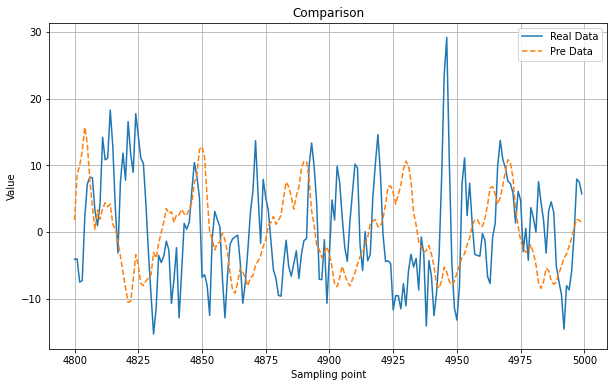

频谱相似度: 0.4338


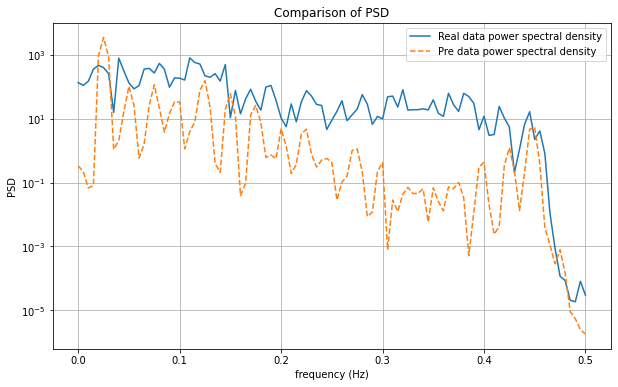

功率谱密度 (PSD) 相似度: 0.3005


In [40]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau
from scipy.signal import welch
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

# 固定随机种子
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# 假设已经有 sampled_data 变量包含了 5000 个点的数据
# 数据划分并标准化
scaler = MinMaxScaler(feature_range=(-1, 1))  # 使用 MinMaxScaler 进行标准化
sampled_data = sampled_data[:5000]  # 已经采样好的5000个点
train_data = scaler.fit_transform(sampled_data[:4800].reshape(-1, 1)).reshape(-1)  # 标准化训练数据
test_data = scaler.transform(sampled_data[4800:].reshape(-1, 1)).reshape(-1)  # 标准化测试数据

n_steps = 30  # 调整时间步长，避免过长的时间依赖造成梯度消失
X = []
y = []

# 构建 LSTM 输入，滑动窗口构造样本
for i in range(len(train_data) - n_steps):
    X.append(train_data[i:i+n_steps])
    y.append(train_data[i+n_steps])

X, y = np.array(X), np.array(y)

# 构建 LSTM 模型，加入 BatchNormalization，使用梯度裁剪防止梯度爆炸
model = Sequential()
model.add(LSTM(50, activation='tanh', return_sequences=True, input_shape=(n_steps, 1)))  # 使用tanh激活函数避免梯度消失
model.add(BatchNormalization())  # 批量归一化
model.add(LSTM(50, activation='tanh'))  # 使用tanh激活函数
model.add(BatchNormalization())  # 批量归一化
model.add(Dense(1))  # 输出层

# 使用梯度裁剪，防止梯度爆炸
optimizer = Adam(learning_rate=0.001, clipvalue=1.0, amsgrad=True)  # clipvalue防止梯度爆炸
model.compile(optimizer=optimizer, loss='mse')

# 学习率调度器，随着训练过程逐步降低学习率
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-6)

# 使用 tqdm 进度条
epochs = 200
with tqdm(total=epochs, desc="Training Progress") as pbar:

    def on_epoch_end(epoch, logs):
        pbar.update(1)

    # 创建 LambdaCallback，来在每个 epoch 结束时更新进度条
    progress_callback = LambdaCallback(on_epoch_end=on_epoch_end)

    # 模型训练
    X = X.reshape((X.shape[0], X.shape[1], 1))  # 调整为 LSTM 输入格式
    model.fit(X, y, epochs=epochs, batch_size=32, shuffle=False, verbose=0, callbacks=[progress_callback, lr_scheduler])

# 用模型预测未来 200 个点
X_input = train_data[-n_steps:].reshape((1, n_steps, 1))  # 取最后 30 个点作为输入
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)

    # 检查预测值是否异常，避免 NaN 或 inf
    if np.isnan(predicted) or np.isinf(predicted):
        print(f'Warning: Invalid predicted value at step {_}, setting to 0.')
        predicted[0][0] = 0  # 处理异常值

    predicted_points.append(predicted[0][0])

    # 滑动窗口更新
    predicted_reshaped = np.array(predicted[0][0]).reshape(1, 1, 1)
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)

predicted_points = np.array(predicted_points)  # 将预测结果转换为 NumPy 数组

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_data.reshape(-1, 1)).reshape(-1)

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制预测结果与真实数据的对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data_rescaled, label='Real Data')
plt.plot(range(4800, 5000), predicted_points_rescaled, label='Pre Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
# 对真实值和预测值做 FFT 变换
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)

# 计算余弦相似度
fft_real_abs = np.abs(fft_real).reshape(1, -1)
fft_pred_abs = np.abs(fft_pred).reshape(1, -1)
spectral_similarity = cosine_similarity(fft_real_abs, fft_pred_abs)[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD) 用于频域特征匹配
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)  # Welch 方法计算真实数据的功率谱密度
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)  # 计算预测数据的功率谱密度

# 绘制功率谱密度对比图
plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real data power spectral density')
plt.semilogy(f_pred, psd_pred, label='Pre data power spectral density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算频域特征匹配度 (余弦相似度)
psd_real = psd_real.reshape(1, -1)
psd_pred = psd_pred.reshape(1, -1)
psd_similarity = cosine_similarity(psd_real, psd_pred)[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')


## seed2345 step30

Training Progress: 100%|█████████████████████████████████████████████████████████████| 200/200 [09:18<00:00,  2.79s/it]


均方根误差 (RMSE): 11.4910


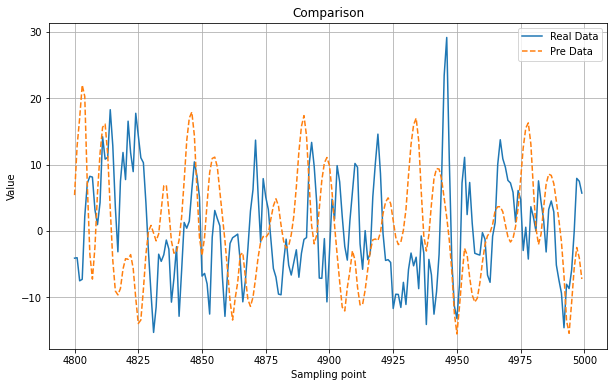

频谱相似度: 0.6736


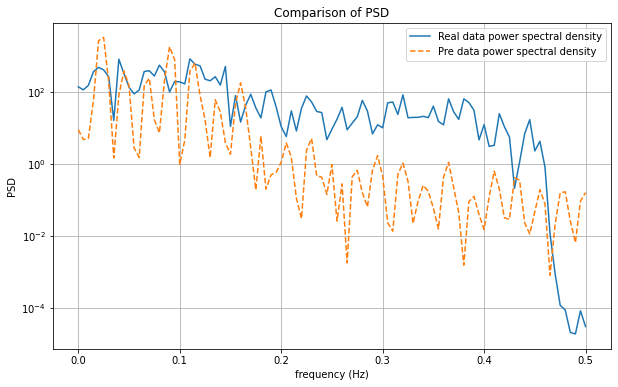

功率谱密度 (PSD) 相似度: 0.4333


In [42]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau
from scipy.signal import welch
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

# 固定随机种子
random.seed(23)
np.random.seed(24)
tf.random.set_seed(25)

# 假设已经有 sampled_data 变量包含了 5000 个点的数据
# 数据划分并标准化
scaler = MinMaxScaler(feature_range=(-1, 1))  # 使用 MinMaxScaler 进行标准化
sampled_data = sampled_data[:5000]  # 已经采样好的5000个点
train_data = scaler.fit_transform(sampled_data[:4800].reshape(-1, 1)).reshape(-1)  # 标准化训练数据
test_data = scaler.transform(sampled_data[4800:].reshape(-1, 1)).reshape(-1)  # 标准化测试数据

n_steps = 30  # 调整时间步长，避免过长的时间依赖造成梯度消失
X = []
y = []

# 构建 LSTM 输入，滑动窗口构造样本
for i in range(len(train_data) - n_steps):
    X.append(train_data[i:i+n_steps])
    y.append(train_data[i+n_steps])

X, y = np.array(X), np.array(y)

# 构建 LSTM 模型，加入 BatchNormalization，使用梯度裁剪防止梯度爆炸
model = Sequential()
model.add(LSTM(50, activation='tanh', return_sequences=True, input_shape=(n_steps, 1)))  # 使用tanh激活函数避免梯度消失
model.add(BatchNormalization())  # 批量归一化
model.add(LSTM(50, activation='tanh'))  # 使用tanh激活函数
model.add(BatchNormalization())  # 批量归一化
model.add(Dense(1))  # 输出层

# 使用梯度裁剪，防止梯度爆炸
optimizer = Adam(learning_rate=0.001, clipvalue=1.0, amsgrad=True)  # clipvalue防止梯度爆炸
model.compile(optimizer=optimizer, loss='mse')

# 学习率调度器，随着训练过程逐步降低学习率
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-6)

# 使用 tqdm 进度条
epochs = 200
with tqdm(total=epochs, desc="Training Progress") as pbar:

    def on_epoch_end(epoch, logs):
        pbar.update(1)

    # 创建 LambdaCallback，来在每个 epoch 结束时更新进度条
    progress_callback = LambdaCallback(on_epoch_end=on_epoch_end)

    # 模型训练
    X = X.reshape((X.shape[0], X.shape[1], 1))  # 调整为 LSTM 输入格式
    model.fit(X, y, epochs=epochs, batch_size=32, shuffle=False, verbose=0, callbacks=[progress_callback, lr_scheduler])

# 用模型预测未来 200 个点
X_input = train_data[-n_steps:].reshape((1, n_steps, 1))  # 取最后 30 个点作为输入
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)

    # 检查预测值是否异常，避免 NaN 或 inf
    if np.isnan(predicted) or np.isinf(predicted):
        print(f'Warning: Invalid predicted value at step {_}, setting to 0.')
        predicted[0][0] = 0  # 处理异常值

    predicted_points.append(predicted[0][0])

    # 滑动窗口更新
    predicted_reshaped = np.array(predicted[0][0]).reshape(1, 1, 1)
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)

predicted_points = np.array(predicted_points)  # 将预测结果转换为 NumPy 数组

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_data.reshape(-1, 1)).reshape(-1)

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制预测结果与真实数据的对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data_rescaled, label='Real Data')
plt.plot(range(4800, 5000), predicted_points_rescaled, label='Pre Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
# 对真实值和预测值做 FFT 变换
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)

# 计算余弦相似度
fft_real_abs = np.abs(fft_real).reshape(1, -1)
fft_pred_abs = np.abs(fft_pred).reshape(1, -1)
spectral_similarity = cosine_similarity(fft_real_abs, fft_pred_abs)[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD) 用于频域特征匹配
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)  # Welch 方法计算真实数据的功率谱密度
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)  # 计算预测数据的功率谱密度

# 绘制功率谱密度对比图
plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real data power spectral density')
plt.semilogy(f_pred, psd_pred, label='Pre data power spectral density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算频域特征匹配度 (余弦相似度)
psd_real = psd_real.reshape(1, -1)
psd_pred = psd_pred.reshape(1, -1)
psd_similarity = cosine_similarity(psd_real, psd_pred)[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')


## step 100

Training Progress: 100%|█████████████████████████████████████████████████████████████| 200/200 [31:47<00:00,  9.54s/it]


均方根误差 (RMSE): 10.0145


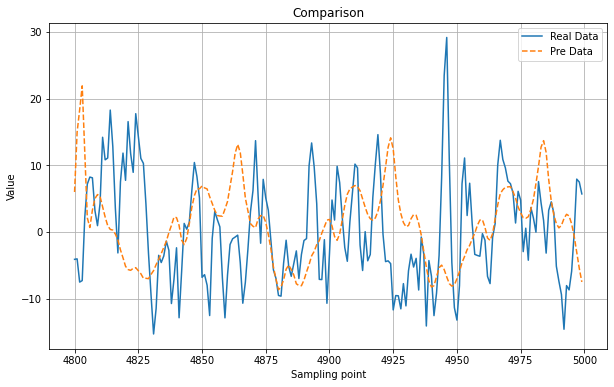

频谱相似度: 0.7463


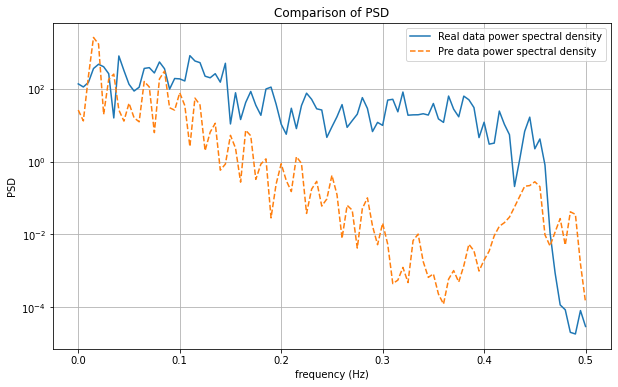

功率谱密度 (PSD) 相似度: 0.3567


In [48]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau
from scipy.signal import welch
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

# 固定随机种子
random.seed(23)
np.random.seed(24)
tf.random.set_seed(25)

# 假设已经有 sampled_data 变量包含了 5000 个点的数据
# 数据划分并标准化
scaler = MinMaxScaler(feature_range=(-1, 1))  # 使用 MinMaxScaler 进行标准化
sampled_data = sampled_data[:5000]  # 已经采样好的5000个点
train_data = scaler.fit_transform(sampled_data[:4800].reshape(-1, 1)).reshape(-1)  # 标准化训练数据
test_data = scaler.transform(sampled_data[4800:].reshape(-1, 1)).reshape(-1)  # 标准化测试数据

n_steps = 100  # 调整时间步长，避免过长的时间依赖造成梯度消失
X = []
y = []

# 构建 LSTM 输入，滑动窗口构造样本
for i in range(len(train_data) - n_steps):
    X.append(train_data[i:i+n_steps])
    y.append(train_data[i+n_steps])

X, y = np.array(X), np.array(y)

# 构建 LSTM 模型，加入 BatchNormalization，使用梯度裁剪防止梯度爆炸
model = Sequential()
model.add(LSTM(50, activation='tanh', return_sequences=True, input_shape=(n_steps, 1)))  # 使用tanh激活函数避免梯度消失
model.add(BatchNormalization())  # 批量归一化
model.add(LSTM(50, activation='tanh'))  # 使用tanh激活函数
model.add(BatchNormalization())  # 批量归一化
model.add(Dense(1))  # 输出层

# 使用梯度裁剪，防止梯度爆炸
optimizer = Adam(learning_rate=0.001, clipvalue=1.0, amsgrad=True)  # clipvalue防止梯度爆炸
model.compile(optimizer=optimizer, loss='mse')

# 学习率调度器，随着训练过程逐步降低学习率
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-6)

# 使用 tqdm 进度条
epochs = 200
with tqdm(total=epochs, desc="Training Progress") as pbar:

    def on_epoch_end(epoch, logs):
        pbar.update(1)

    # 创建 LambdaCallback，来在每个 epoch 结束时更新进度条
    progress_callback = LambdaCallback(on_epoch_end=on_epoch_end)

    # 模型训练
    X = X.reshape((X.shape[0], X.shape[1], 1))  # 调整为 LSTM 输入格式
    model.fit(X, y, epochs=epochs, batch_size=32, shuffle=False, verbose=0, callbacks=[progress_callback, lr_scheduler])

# 用模型预测未来 200 个点
X_input = train_data[-n_steps:].reshape((1, n_steps, 1))  # 取最后 30 个点作为输入
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)

    # 检查预测值是否异常，避免 NaN 或 inf
    if np.isnan(predicted) or np.isinf(predicted):
        print(f'Warning: Invalid predicted value at step {_}, setting to 0.')
        predicted[0][0] = 0  # 处理异常值

    predicted_points.append(predicted[0][0])

    # 滑动窗口更新
    predicted_reshaped = np.array(predicted[0][0]).reshape(1, 1, 1)
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)

predicted_points = np.array(predicted_points)  # 将预测结果转换为 NumPy 数组

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_data.reshape(-1, 1)).reshape(-1)

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制预测结果与真实数据的对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data_rescaled, label='Real Data')
plt.plot(range(4800, 5000), predicted_points_rescaled, label='Pre Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
# 对真实值和预测值做 FFT 变换
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)

# 计算余弦相似度
fft_real_abs = np.abs(fft_real).reshape(1, -1)
fft_pred_abs = np.abs(fft_pred).reshape(1, -1)
spectral_similarity = cosine_similarity(fft_real_abs, fft_pred_abs)[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD) 用于频域特征匹配
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)  # Welch 方法计算真实数据的功率谱密度
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)  # 计算预测数据的功率谱密度

# 绘制功率谱密度对比图
plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real data power spectral density')
plt.semilogy(f_pred, psd_pred, label='Pre data power spectral density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算频域特征匹配度 (余弦相似度)
psd_real = psd_real.reshape(1, -1)
psd_pred = psd_pred.reshape(1, -1)
psd_similarity = cosine_similarity(psd_real, psd_pred)[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')


## step 50

Training Progress: 100%|█████████████████████████████████████████████████████████████| 200/200 [16:10<00:00,  4.85s/it]


均方根误差 (RMSE): 9.5987


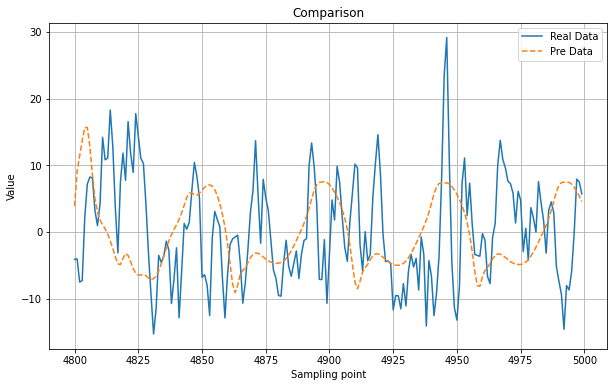

频谱相似度: 0.6582


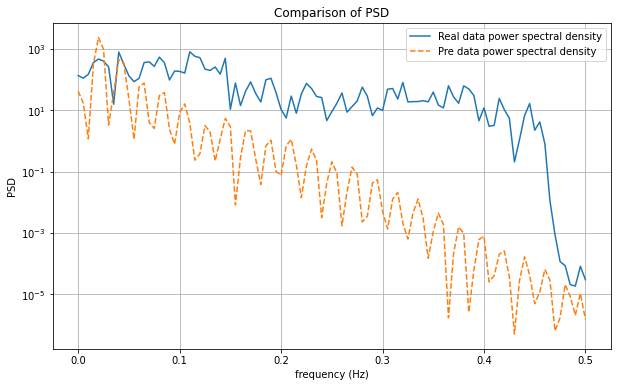

功率谱密度 (PSD) 相似度: 0.4080


In [47]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau
from scipy.signal import welch
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

# 固定随机种子
random.seed(23)
np.random.seed(24)
tf.random.set_seed(25)

# 数据划分并标准化
scaler = MinMaxScaler(feature_range=(-1, 1))  # 使用 MinMaxScaler 进行标准化
sampled_data = sampled_data[:5000]  # 已经采样好的5000个点
train_data = scaler.fit_transform(sampled_data[:4800].reshape(-1, 1)).reshape(-1)  # 标准化训练数据
test_data = scaler.transform(sampled_data[4800:].reshape(-1, 1)).reshape(-1)  # 标准化测试数据

n_steps = 50  # 调整时间步长，避免过长的时间依赖造成梯度消失
X = []
y = []

# 构建 LSTM 输入，滑动窗口构造样本
for i in range(len(train_data) - n_steps):
    X.append(train_data[i:i+n_steps])
    y.append(train_data[i+n_steps])

X, y = np.array(X), np.array(y)

# 构建 LSTM 模型，加入 BatchNormalization，使用梯度裁剪防止梯度爆炸
model = Sequential()
model.add(LSTM(50, activation='tanh', return_sequences=True, input_shape=(n_steps, 1)))  # 使用tanh激活函数避免梯度消失
model.add(BatchNormalization())  # 批量归一化
model.add(LSTM(50, activation='tanh'))  # 使用tanh激活函数
model.add(BatchNormalization())  # 批量归一化
model.add(Dense(1))  # 输出层

# 使用梯度裁剪，防止梯度爆炸
optimizer = Adam(learning_rate=0.001, clipvalue=1.0, amsgrad=True)  # clipvalue防止梯度爆炸
model.compile(optimizer=optimizer, loss='mse')

# 学习率调度器，随着训练过程逐步降低学习率
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-6)

# 使用 tqdm 进度条
epochs = 200
with tqdm(total=epochs, desc="Training Progress") as pbar:

    def on_epoch_end(epoch, logs):
        pbar.update(1)

    # 创建 LambdaCallback，来在每个 epoch 结束时更新进度条
    progress_callback = LambdaCallback(on_epoch_end=on_epoch_end)

    # 模型训练
    X = X.reshape((X.shape[0], X.shape[1], 1))  # 调整为 LSTM 输入格式
    model.fit(X, y, epochs=epochs, batch_size=32, shuffle=False, verbose=0, callbacks=[progress_callback, lr_scheduler])

# 用模型预测未来 200 个点
X_input = train_data[-n_steps:].reshape((1, n_steps, 1))  # 取最后 30 个点作为输入
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)

    # 检查预测值是否异常，避免 NaN 或 inf
    if np.isnan(predicted) or np.isinf(predicted):
        print(f'Warning: Invalid predicted value at step {_}, setting to 0.')
        predicted[0][0] = 0  # 处理异常值

    predicted_points.append(predicted[0][0])

    # 滑动窗口更新
    predicted_reshaped = np.array(predicted[0][0]).reshape(1, 1, 1)
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)

predicted_points = np.array(predicted_points)  # 将预测结果转换为 NumPy 数组

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_data.reshape(-1, 1)).reshape(-1)

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制预测结果与真实数据的对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data_rescaled, label='Real Data')
plt.plot(range(4800, 5000), predicted_points_rescaled, label='Pre Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
# 对真实值和预测值做 FFT 变换
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)

# 计算余弦相似度
fft_real_abs = np.abs(fft_real).reshape(1, -1)
fft_pred_abs = np.abs(fft_pred).reshape(1, -1)
spectral_similarity = cosine_similarity(fft_real_abs, fft_pred_abs)[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD) 用于频域特征匹配
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)  # Welch 方法计算真实数据的功率谱密度
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)  # 计算预测数据的功率谱密度

# 绘制功率谱密度对比图
plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real data power spectral density')
plt.semilogy(f_pred, psd_pred, label='Pre data power spectral density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')  
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算频域特征匹配度 (余弦相似度)
psd_real = psd_real.reshape(1, -1)
psd_pred = psd_pred.reshape(1, -1)
psd_similarity = cosine_similarity(psd_real, psd_pred)[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')


## step15

Training Progress: 100%|█████████████████████████████████████████████████████████████| 200/200 [05:15<00:00,  1.58s/it]


均方根误差 (RMSE): 9.4242


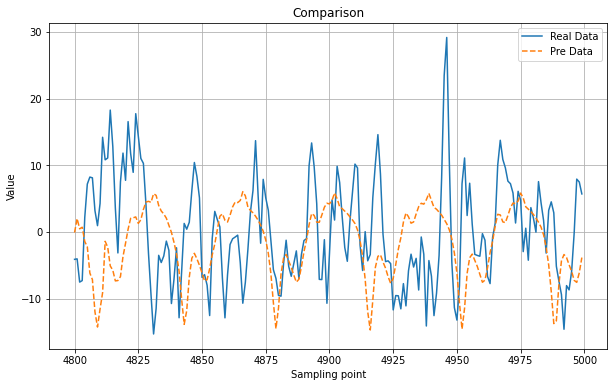

频谱相似度: 0.6421


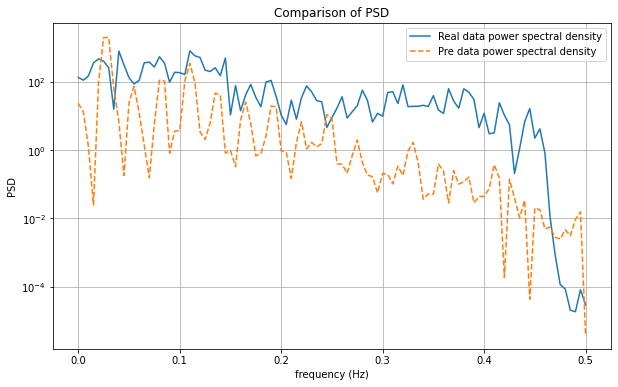

功率谱密度 (PSD) 相似度: 0.3251


In [49]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau
from scipy.signal import welch
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

# 固定随机种子
random.seed(23)
np.random.seed(24)
tf.random.set_seed(25)

# 假设已经有 sampled_data 变量包含了 5000 个点的数据
# 数据划分并标准化
scaler = MinMaxScaler(feature_range=(-1, 1))  # 使用 MinMaxScaler 进行标准化
sampled_data = sampled_data[:5000]  # 已经采样好的5000个点
train_data = scaler.fit_transform(sampled_data[:4800].reshape(-1, 1)).reshape(-1)  # 标准化训练数据
test_data = scaler.transform(sampled_data[4800:].reshape(-1, 1)).reshape(-1)  # 标准化测试数据

n_steps = 15  # 调整时间步长，避免过长的时间依赖造成梯度消失
X = []
y = []

# 构建 LSTM 输入，滑动窗口构造样本
for i in range(len(train_data) - n_steps):
    X.append(train_data[i:i+n_steps])
    y.append(train_data[i+n_steps])

X, y = np.array(X), np.array(y)

# 构建 LSTM 模型，加入 BatchNormalization，使用梯度裁剪防止梯度爆炸
model = Sequential()
model.add(LSTM(50, activation='tanh', return_sequences=True, input_shape=(n_steps, 1)))  # 使用tanh激活函数避免梯度消失
model.add(BatchNormalization())  # 批量归一化
model.add(LSTM(50, activation='tanh'))  # 使用tanh激活函数
model.add(BatchNormalization())  # 批量归一化
model.add(Dense(1))  # 输出层

# 使用梯度裁剪，防止梯度爆炸
optimizer = Adam(learning_rate=0.001, clipvalue=1.0, amsgrad=True)  # clipvalue防止梯度爆炸
model.compile(optimizer=optimizer, loss='mse')

# 学习率调度器，随着训练过程逐步降低学习率
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-6)

# 使用 tqdm 进度条
epochs = 200
with tqdm(total=epochs, desc="Training Progress") as pbar:

    def on_epoch_end(epoch, logs):
        pbar.update(1)

    # 创建 LambdaCallback，来在每个 epoch 结束时更新进度条
    progress_callback = LambdaCallback(on_epoch_end=on_epoch_end)

    # 模型训练
    X = X.reshape((X.shape[0], X.shape[1], 1))  # 调整为 LSTM 输入格式
    model.fit(X, y, epochs=epochs, batch_size=32, shuffle=False, verbose=0, callbacks=[progress_callback, lr_scheduler])

# 用模型预测未来 200 个点
X_input = train_data[-n_steps:].reshape((1, n_steps, 1))  # 取最后 30 个点作为输入
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)

    # 检查预测值是否异常，避免 NaN 或 inf
    if np.isnan(predicted) or np.isinf(predicted):
        print(f'Warning: Invalid predicted value at step {_}, setting to 0.')
        predicted[0][0] = 0  # 处理异常值

    predicted_points.append(predicted[0][0])

    # 滑动窗口更新
    predicted_reshaped = np.array(predicted[0][0]).reshape(1, 1, 1)
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)

predicted_points = np.array(predicted_points)  # 将预测结果转换为 NumPy 数组

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_data.reshape(-1, 1)).reshape(-1)

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制预测结果与真实数据的对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data_rescaled, label='Real Data')
plt.plot(range(4800, 5000), predicted_points_rescaled, label='Pre Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
# 对真实值和预测值做 FFT 变换
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)

# 计算余弦相似度
fft_real_abs = np.abs(fft_real).reshape(1, -1)
fft_pred_abs = np.abs(fft_pred).reshape(1, -1)
spectral_similarity = cosine_similarity(fft_real_abs, fft_pred_abs)[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD) 用于频域特征匹配
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)  # Welch 方法计算真实数据的功率谱密度
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)  # 计算预测数据的功率谱密度

# 绘制功率谱密度对比图
plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real data power spectral density')
plt.semilogy(f_pred, psd_pred, label='Pre data power spectral density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算频域特征匹配度 (余弦相似度)
psd_real = psd_real.reshape(1, -1)
psd_pred = psd_pred.reshape(1, -1)
psd_similarity = cosine_similarity(psd_real, psd_pred)[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')


## step200

Training Progress: 100%|███████████████████████████████████████████████████████████| 200/200 [1:06:54<00:00, 20.07s/it]


均方根误差 (RMSE): 10.8838


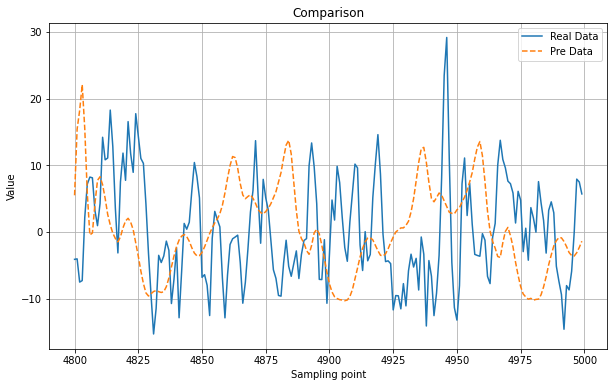

频谱相似度: 0.6932


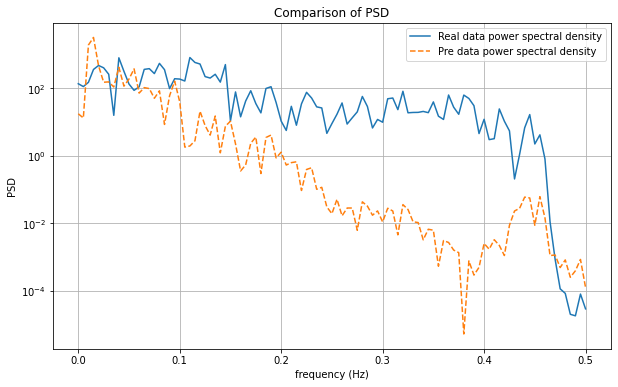

功率谱密度 (PSD) 相似度: 0.3124


In [50]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau
from scipy.signal import welch
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

# 固定随机种子
random.seed(23)
np.random.seed(24)
tf.random.set_seed(25)

# 假设已经有 sampled_data 变量包含了 5000 个点的数据
# 数据划分并标准化
scaler = MinMaxScaler(feature_range=(-1, 1))  # 使用 MinMaxScaler 进行标准化
sampled_data = sampled_data[:5000]  # 已经采样好的5000个点
train_data = scaler.fit_transform(sampled_data[:4800].reshape(-1, 1)).reshape(-1)  # 标准化训练数据
test_data = scaler.transform(sampled_data[4800:].reshape(-1, 1)).reshape(-1)  # 标准化测试数据

n_steps = 200  # 调整时间步长，避免过长的时间依赖造成梯度消失
X = []
y = []

# 构建 LSTM 输入，滑动窗口构造样本
for i in range(len(train_data) - n_steps):
    X.append(train_data[i:i+n_steps])
    y.append(train_data[i+n_steps])

X, y = np.array(X), np.array(y)

# 构建 LSTM 模型，加入 BatchNormalization，使用梯度裁剪防止梯度爆炸
model = Sequential()
model.add(LSTM(50, activation='tanh', return_sequences=True, input_shape=(n_steps, 1)))  # 使用tanh激活函数避免梯度消失
model.add(BatchNormalization())  # 批量归一化
model.add(LSTM(50, activation='tanh'))  # 使用tanh激活函数
model.add(BatchNormalization())  # 批量归一化
model.add(Dense(1))  # 输出层

# 使用梯度裁剪，防止梯度爆炸
optimizer = Adam(learning_rate=0.001, clipvalue=1.0, amsgrad=True)  # clipvalue防止梯度爆炸
model.compile(optimizer=optimizer, loss='mse')

# 学习率调度器，随着训练过程逐步降低学习率
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-6)

# 使用 tqdm 进度条
epochs = 200
with tqdm(total=epochs, desc="Training Progress") as pbar:

    def on_epoch_end(epoch, logs):
        pbar.update(1)

    # 创建 LambdaCallback，来在每个 epoch 结束时更新进度条
    progress_callback = LambdaCallback(on_epoch_end=on_epoch_end)

    # 模型训练
    X = X.reshape((X.shape[0], X.shape[1], 1))  # 调整为 LSTM 输入格式
    model.fit(X, y, epochs=epochs, batch_size=32, shuffle=False, verbose=0, callbacks=[progress_callback, lr_scheduler])

# 用模型预测未来 200 个点
X_input = train_data[-n_steps:].reshape((1, n_steps, 1))  # 取最后 30 个点作为输入
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)

    # 检查预测值是否异常，避免 NaN 或 inf
    if np.isnan(predicted) or np.isinf(predicted):
        print(f'Warning: Invalid predicted value at step {_}, setting to 0.')
        predicted[0][0] = 0  # 处理异常值

    predicted_points.append(predicted[0][0])

    # 滑动窗口更新
    predicted_reshaped = np.array(predicted[0][0]).reshape(1, 1, 1)
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)

predicted_points = np.array(predicted_points)  # 将预测结果转换为 NumPy 数组

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_data.reshape(-1, 1)).reshape(-1)

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制预测结果与真实数据的对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data_rescaled, label='Real Data')
plt.plot(range(4800, 5000), predicted_points_rescaled, label='Pre Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
# 对真实值和预测值做 FFT 变换
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)

# 计算余弦相似度
fft_real_abs = np.abs(fft_real).reshape(1, -1)
fft_pred_abs = np.abs(fft_pred).reshape(1, -1)
spectral_similarity = cosine_similarity(fft_real_abs, fft_pred_abs)[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD) 用于频域特征匹配
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)  # Welch 方法计算真实数据的功率谱密度
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)  # 计算预测数据的功率谱密度

# 绘制功率谱密度对比图
plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real data power spectral density')
plt.semilogy(f_pred, psd_pred, label='Pre data power spectral density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算频域特征匹配度 (余弦相似度)
psd_real = psd_real.reshape(1, -1)
psd_pred = psd_pred.reshape(1, -1)
psd_similarity = cosine_similarity(psd_real, psd_pred)[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')


## 2000点 50hz秒级预测

In [2]:
import scipy.io as scio
import matplotlib.pyplot as plt

data = scio.loadmat('C:/Users/Brilliant/Desktop/data.mat')

matrix_data = data['data']

print(f"\nType of 'data':", type(matrix_data))
print(f"Shape of 'data':", matrix_data.shape)
data = scio.loadmat('C:/Users/Brilliant/Desktop/data.mat')
matrix_data = data['data']
# 提取第一行（第一通道的EEG数据）
first_channel = matrix_data[0, :]
sampled_data = first_channel[:500000:10]
len(sampled_data)


Type of 'data': <class 'numpy.ndarray'>
Shape of 'data': (16, 604700)


50000

Training Progress: 100%|███████████████████████████████████████████████████████████| 200/200 [1:29:52<00:00, 26.96s/it]


均方根误差 (RMSE): 11.1124


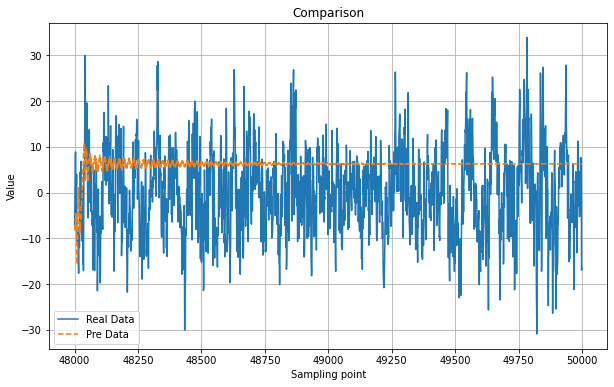

频谱相似度: 0.1933


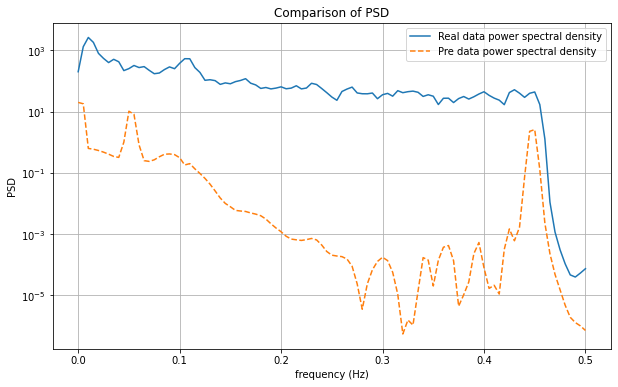

功率谱密度 (PSD) 相似度: 0.3253


In [3]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau
from scipy.signal import welch
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

# 固定随机种子
random.seed(23)
np.random.seed(24)
tf.random.set_seed(25)

# 假设已经有 sampled_data 变量包含了 5000 个点的数据
# 数据划分并标准化
scaler = MinMaxScaler(feature_range=(-1, 1))  # 使用 MinMaxScaler 进行标准化
sampled_data = sampled_data[:50000]  # 已经采样好的5000个点
train_data = scaler.fit_transform(sampled_data[:48000].reshape(-1, 1)).reshape(-1)  # 标准化训练数据
test_data = scaler.transform(sampled_data[48000:].reshape(-1, 1)).reshape(-1)  # 标准化测试数据

n_steps = 30  # 调整时间步长，避免过长的时间依赖造成梯度消失
X = []
y = []

# 构建 LSTM 输入，滑动窗口构造样本
for i in range(len(train_data) - n_steps):
    X.append(train_data[i:i+n_steps])
    y.append(train_data[i+n_steps])

X, y = np.array(X), np.array(y)

# 构建 LSTM 模型，加入 BatchNormalization，使用梯度裁剪防止梯度爆炸
model = Sequential()
model.add(LSTM(50, activation='tanh', return_sequences=True, input_shape=(n_steps, 1)))  # 使用tanh激活函数避免梯度消失
model.add(BatchNormalization())  # 批量归一化
model.add(LSTM(50, activation='tanh'))  # 使用tanh激活函数
model.add(BatchNormalization())  # 批量归一化
model.add(Dense(1))  # 输出层

# 使用梯度裁剪，防止梯度爆炸
optimizer = Adam(learning_rate=0.001, clipvalue=1.0, amsgrad=True)  # clipvalue防止梯度爆炸
model.compile(optimizer=optimizer, loss='mse')

# 学习率调度器，随着训练过程逐步降低学习率
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-6)

# 使用 tqdm 进度条
epochs = 200
with tqdm(total=epochs, desc="Training Progress") as pbar:

    def on_epoch_end(epoch, logs):
        pbar.update(1)

    # 创建 LambdaCallback，来在每个 epoch 结束时更新进度条
    progress_callback = LambdaCallback(on_epoch_end=on_epoch_end)

    # 模型训练
    X = X.reshape((X.shape[0], X.shape[1], 1))  # 调整为 LSTM 输入格式
    model.fit(X, y, epochs=epochs, batch_size=32, shuffle=False, verbose=0, callbacks=[progress_callback, lr_scheduler])

# 用模型预测未来 2000 个点
X_input = train_data[-n_steps:].reshape((1, n_steps, 1))  # 取最后 30 个点作为输入
predicted_points = []

for _ in range(2000):
    predicted = model.predict(X_input, verbose=0)

    # 检查预测值是否异常，避免 NaN 或 inf
    if np.isnan(predicted) or np.isinf(predicted):
        print(f'Warning: Invalid predicted value at step {_}, setting to 0.')
        predicted[0][0] = 0  # 处理异常值

    predicted_points.append(predicted[0][0])

    # 滑动窗口更新
    predicted_reshaped = np.array(predicted[0][0]).reshape(1, 1, 1)
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)

predicted_points = np.array(predicted_points)  # 将预测结果转换为 NumPy 数组

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_data.reshape(-1, 1)).reshape(-1)

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制预测结果与真实数据的对比图
plt.figure(figsize=(10, 6))
plt.plot(range(48000, 50000), test_data_rescaled, label='Real Data')
plt.plot(range(48000, 50000), predicted_points_rescaled, label='Pre Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
# 对真实值和预测值做 FFT 变换
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)

# 计算余弦相似度
fft_real_abs = np.abs(fft_real).reshape(1, -1)
fft_pred_abs = np.abs(fft_pred).reshape(1, -1)
spectral_similarity = cosine_similarity(fft_real_abs, fft_pred_abs)[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD) 用于频域特征匹配
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)  # Welch 方法计算真实数据的功率谱密度
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)  # 计算预测数据的功率谱密度

# 绘制功率谱密度对比图
plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real data power spectral density')
plt.semilogy(f_pred, psd_pred, label='Pre data power spectral density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算频域特征匹配度 (余弦相似度)
psd_real = psd_real.reshape(1, -1)
psd_pred = psd_pred.reshape(1, -1)
psd_similarity = cosine_similarity(psd_real, psd_pred)[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')

In [4]:
data = scio.loadmat('C:/Users/Brilliant/Desktop/data.mat')
matrix_data = data['data']
# 提取第一行（第一通道的EEG数据）
first_channel = matrix_data[0, :]
sampled_data = first_channel[:50000:10]
len(sampled_data)

5000

## 学习率可调 learning_rate控制变量  调度器min递减

Training Progress: 100%|█████████████████████████████████████████████████████████████| 200/200 [17:37<00:00,  5.29s/it]


均方根误差 (RMSE): 11.4910


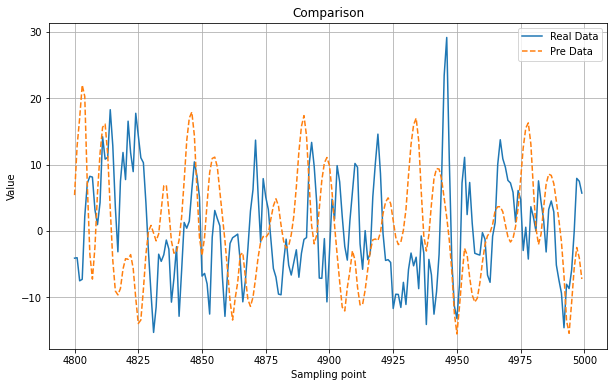

频谱相似度: 0.6736


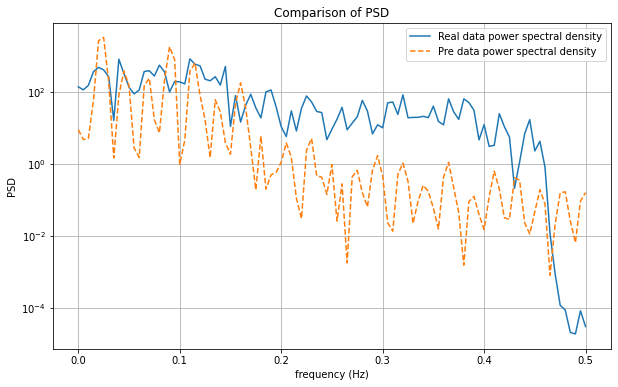

功率谱密度 (PSD) 相似度: 0.4333


In [8]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau
from scipy.signal import welch
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

# 固定随机种子
random.seed(25)
np.random.seed(25)
tf.random.set_seed(25)

# 假设已经有 sampled_data 变量包含了 5000 个点的数据
# 数据划分并标准化
scaler = MinMaxScaler(feature_range=(-1, 1))  # 使用 MinMaxScaler 进行标准化
sampled_data = sampled_data[:5000]  # 已经采样好的5000个点
train_data = scaler.fit_transform(sampled_data[:4800].reshape(-1, 1)).reshape(-1)  # 标准化训练数据
test_data = scaler.transform(sampled_data[4800:].reshape(-1, 1)).reshape(-1)  # 标准化测试数据

n_steps = 30  # 调整时间步长，避免过长的时间依赖造成梯度消失
X = []
y = []

# 构建 LSTM 输入，滑动窗口构造样本
for i in range(len(train_data) - n_steps):
    X.append(train_data[i:i+n_steps])
    y.append(train_data[i+n_steps])

X, y = np.array(X), np.array(y)

# 构建 LSTM 模型，加入 BatchNormalization，使用梯度裁剪防止梯度爆炸
model = Sequential()
model.add(LSTM(50, activation='tanh', return_sequences=True, input_shape=(n_steps, 1)))  # 使用tanh激活函数避免梯度消失
model.add(BatchNormalization())  # 批量归一化
model.add(LSTM(50, activation='tanh'))  # 使用tanh激活函数
model.add(BatchNormalization())  # 批量归一化
model.add(Dense(1))  # 输出层

# 使用梯度裁剪，防止梯度爆炸
optimizer = Adam(learning_rate=0.001, clipvalue=1.0, amsgrad=True)  # clipvalue防止梯度爆炸
model.compile(optimizer=optimizer, loss='mse')

# 学习率调度器，随着训练过程逐步降低学习率
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-6)

# 使用 tqdm 进度条
epochs = 200
with tqdm(total=epochs, desc="Training Progress") as pbar:

    def on_epoch_end(epoch, logs):
        pbar.update(1)

    # 创建 LambdaCallback，来在每个 epoch 结束时更新进度条
    progress_callback = LambdaCallback(on_epoch_end=on_epoch_end)

    # 模型训练
    X = X.reshape((X.shape[0], X.shape[1], 1))  # 调整为 LSTM 输入格式
    model.fit(X, y, epochs=epochs, batch_size=32, shuffle=False, verbose=0, callbacks=[progress_callback, lr_scheduler])

# 用模型预测未来 200 个点
X_input = train_data[-n_steps:].reshape((1, n_steps, 1))  # 取最后 30 个点作为输入
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)

    # 检查预测值是否异常，避免 NaN 或 inf
    if np.isnan(predicted) or np.isinf(predicted):
        print(f'Warning: Invalid predicted value at step {_}, setting to 0.')
        predicted[0][0] = 0  # 处理异常值

    predicted_points.append(predicted[0][0])

    # 滑动窗口更新
    predicted_reshaped = np.array(predicted[0][0]).reshape(1, 1, 1)
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)

predicted_points = np.array(predicted_points)  # 将预测结果转换为 NumPy 数组

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_data.reshape(-1, 1)).reshape(-1)

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制预测结果与真实数据的对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data_rescaled, label='Real Data')
plt.plot(range(4800, 5000), predicted_points_rescaled, label='Pre Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
# 对真实值和预测值做 FFT 变换
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)

# 计算余弦相似度
fft_real_abs = np.abs(fft_real).reshape(1, -1)
fft_pred_abs = np.abs(fft_pred).reshape(1, -1)
spectral_similarity = cosine_similarity(fft_real_abs, fft_pred_abs)[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD) 用于频域特征匹配
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)  # Welch 方法计算真实数据的功率谱密度
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)  # 计算预测数据的功率谱密度

# 绘制功率谱密度对比图
plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real data power spectral density')
plt.semilogy(f_pred, psd_pred, label='Pre data power spectral density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算频域特征匹配度 (余弦相似度)
psd_real = psd_real.reshape(1, -1)
psd_pred = psd_pred.reshape(1, -1)
psd_similarity = cosine_similarity(psd_real, psd_pred)[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')


Training Progress: 100%|█████████████████████████████████████████████████████████████| 200/200 [18:51<00:00,  5.66s/it]


均方根误差 (RMSE): 10.1360


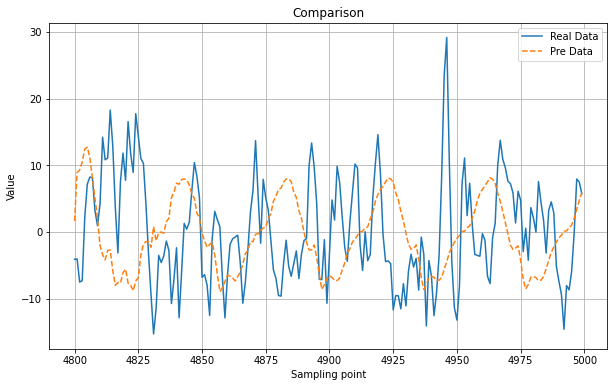

频谱相似度: 0.3449


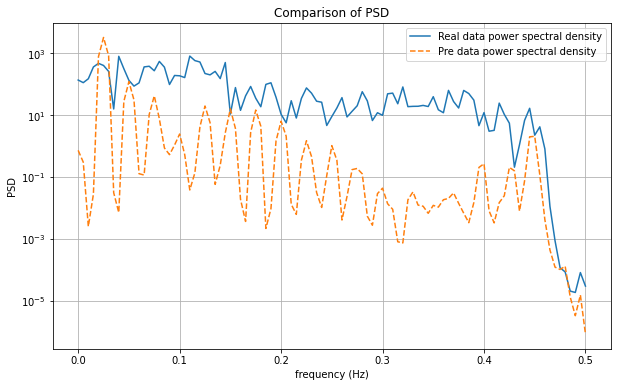

功率谱密度 (PSD) 相似度: 0.2807


In [9]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau
from scipy.signal import welch
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

# 固定随机种子
random.seed(100)
np.random.seed(100)
tf.random.set_seed(100)

# 假设已经有 sampled_data 变量包含了 5000 个点的数据
# 数据划分并标准化
scaler = MinMaxScaler(feature_range=(-1, 1))  # 使用 MinMaxScaler 进行标准化
sampled_data = sampled_data[:5000]  # 已经采样好的5000个点
train_data = scaler.fit_transform(sampled_data[:4800].reshape(-1, 1)).reshape(-1)  # 标准化训练数据
test_data = scaler.transform(sampled_data[4800:].reshape(-1, 1)).reshape(-1)  # 标准化测试数据

n_steps = 30  # 调整时间步长，避免过长的时间依赖造成梯度消失
X = []
y = []

# 构建 LSTM 输入，滑动窗口构造样本
for i in range(len(train_data) - n_steps):
    X.append(train_data[i:i+n_steps])
    y.append(train_data[i+n_steps])

X, y = np.array(X), np.array(y)

# 构建 LSTM 模型，加入 BatchNormalization，使用梯度裁剪防止梯度爆炸
model = Sequential()
model.add(LSTM(50, activation='tanh', return_sequences=True, input_shape=(n_steps, 1)))  # 使用tanh激活函数避免梯度消失
model.add(BatchNormalization())  # 批量归一化
model.add(LSTM(50, activation='tanh'))  # 使用tanh激活函数
model.add(BatchNormalization())  # 批量归一化
model.add(Dense(1))  # 输出层

# 使用梯度裁剪，防止梯度爆炸
optimizer = Adam(learning_rate=0.001, clipvalue=1.0, amsgrad=True)  # clipvalue防止梯度爆炸
model.compile(optimizer=optimizer, loss='mse')

# 学习率调度器，随着训练过程逐步降低学习率
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-6)

# 使用 tqdm 进度条
epochs = 200
with tqdm(total=epochs, desc="Training Progress") as pbar:

    def on_epoch_end(epoch, logs):
        pbar.update(1)

    # 创建 LambdaCallback，来在每个 epoch 结束时更新进度条
    progress_callback = LambdaCallback(on_epoch_end=on_epoch_end)

    # 模型训练
    X = X.reshape((X.shape[0], X.shape[1], 1))  # 调整为 LSTM 输入格式
    model.fit(X, y, epochs=epochs, batch_size=32, shuffle=False, verbose=0, callbacks=[progress_callback, lr_scheduler])

# 用模型预测未来 200 个点
X_input = train_data[-n_steps:].reshape((1, n_steps, 1))  # 取最后 30 个点作为输入
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)

    # 检查预测值是否异常，避免 NaN 或 inf
    if np.isnan(predicted) or np.isinf(predicted):
        print(f'Warning: Invalid predicted value at step {_}, setting to 0.')
        predicted[0][0] = 0  # 处理异常值

    predicted_points.append(predicted[0][0])

    # 滑动窗口更新
    predicted_reshaped = np.array(predicted[0][0]).reshape(1, 1, 1)
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)

predicted_points = np.array(predicted_points)  # 将预测结果转换为 NumPy 数组

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_data.reshape(-1, 1)).reshape(-1)

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制预测结果与真实数据的对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data_rescaled, label='Real Data')
plt.plot(range(4800, 5000), predicted_points_rescaled, label='Pre Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
# 对真实值和预测值做 FFT 变换
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)

# 计算余弦相似度
fft_real_abs = np.abs(fft_real).reshape(1, -1)
fft_pred_abs = np.abs(fft_pred).reshape(1, -1)
spectral_similarity = cosine_similarity(fft_real_abs, fft_pred_abs)[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD) 用于频域特征匹配
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)  # Welch 方法计算真实数据的功率谱密度
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)  # 计算预测数据的功率谱密度

# 绘制功率谱密度对比图
plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real data power spectral density')
plt.semilogy(f_pred, psd_pred, label='Pre data power spectral density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算频域特征匹配度 (余弦相似度)
psd_real = psd_real.reshape(1, -1)
psd_pred = psd_pred.reshape(1, -1)
psd_similarity = cosine_similarity(psd_real, psd_pred)[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')


Training Progress: 100%|█████████████████████████████████████████████████████████████| 200/200 [19:49<00:00,  5.95s/it]


均方根误差 (RMSE): 10.2244


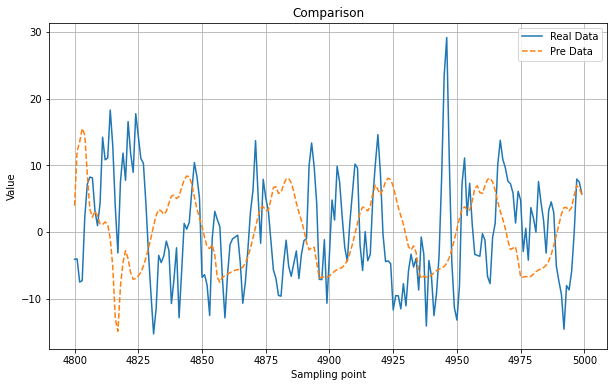

频谱相似度: 0.4060


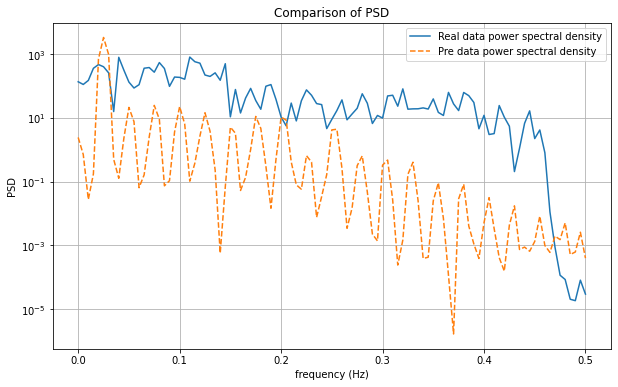

功率谱密度 (PSD) 相似度: 0.2738


In [10]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau
from scipy.signal import welch
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

# 固定随机种子
random.seed(300)
np.random.seed(300)
tf.random.set_seed(300)

# 假设已经有 sampled_data 变量包含了 5000 个点的数据
# 数据划分并标准化
scaler = MinMaxScaler(feature_range=(-1, 1))  # 使用 MinMaxScaler 进行标准化
sampled_data = sampled_data[:5000]  # 已经采样好的5000个点
train_data = scaler.fit_transform(sampled_data[:4800].reshape(-1, 1)).reshape(-1)  # 标准化训练数据
test_data = scaler.transform(sampled_data[4800:].reshape(-1, 1)).reshape(-1)  # 标准化测试数据

n_steps = 30  # 调整时间步长，避免过长的时间依赖造成梯度消失
X = []
y = []

# 构建 LSTM 输入，滑动窗口构造样本
for i in range(len(train_data) - n_steps):
    X.append(train_data[i:i+n_steps])
    y.append(train_data[i+n_steps])

X, y = np.array(X), np.array(y)

# 构建 LSTM 模型，加入 BatchNormalization，使用梯度裁剪防止梯度爆炸
model = Sequential()
model.add(LSTM(50, activation='tanh', return_sequences=True, input_shape=(n_steps, 1)))  # 使用tanh激活函数避免梯度消失
model.add(BatchNormalization())  # 批量归一化
model.add(LSTM(50, activation='tanh'))  # 使用tanh激活函数
model.add(BatchNormalization())  # 批量归一化
model.add(Dense(1))  # 输出层

# 使用梯度裁剪，防止梯度爆炸
optimizer = Adam(learning_rate=0.001, clipvalue=1.0, amsgrad=True)  # clipvalue防止梯度爆炸
model.compile(optimizer=optimizer, loss='mse')

# 学习率调度器，随着训练过程逐步降低学习率
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-6)

# 使用 tqdm 进度条
epochs = 200
with tqdm(total=epochs, desc="Training Progress") as pbar:

    def on_epoch_end(epoch, logs):
        pbar.update(1)

    # 创建 LambdaCallback，来在每个 epoch 结束时更新进度条
    progress_callback = LambdaCallback(on_epoch_end=on_epoch_end)

    # 模型训练
    X = X.reshape((X.shape[0], X.shape[1], 1))  # 调整为 LSTM 输入格式
    model.fit(X, y, epochs=epochs, batch_size=32, shuffle=False, verbose=0, callbacks=[progress_callback, lr_scheduler])

# 用模型预测未来 200 个点
X_input = train_data[-n_steps:].reshape((1, n_steps, 1))  # 取最后 30 个点作为输入
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)

    # 检查预测值是否异常，避免 NaN 或 inf
    if np.isnan(predicted) or np.isinf(predicted):
        print(f'Warning: Invalid predicted value at step {_}, setting to 0.')
        predicted[0][0] = 0  # 处理异常值

    predicted_points.append(predicted[0][0])

    # 滑动窗口更新
    predicted_reshaped = np.array(predicted[0][0]).reshape(1, 1, 1)
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)

predicted_points = np.array(predicted_points)  # 将预测结果转换为 NumPy 数组

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_data.reshape(-1, 1)).reshape(-1)

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制预测结果与真实数据的对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data_rescaled, label='Real Data')
plt.plot(range(4800, 5000), predicted_points_rescaled, label='Pre Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
# 对真实值和预测值做 FFT 变换
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)

# 计算余弦相似度
fft_real_abs = np.abs(fft_real).reshape(1, -1)
fft_pred_abs = np.abs(fft_pred).reshape(1, -1)
spectral_similarity = cosine_similarity(fft_real_abs, fft_pred_abs)[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD) 用于频域特征匹配
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)  # Welch 方法计算真实数据的功率谱密度
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)  # 计算预测数据的功率谱密度

# 绘制功率谱密度对比图
plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real data power spectral density')
plt.semilogy(f_pred, psd_pred, label='Pre data power spectral density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算频域特征匹配度 (余弦相似度)
psd_real = psd_real.reshape(1, -1)
psd_pred = psd_pred.reshape(1, -1)
psd_similarity = cosine_similarity(psd_real, psd_pred)[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')


Training Progress: 100%|█████████████████████████████████████████████████████████████| 200/200 [21:24<00:00,  6.42s/it]


均方根误差 (RMSE): 9.1924


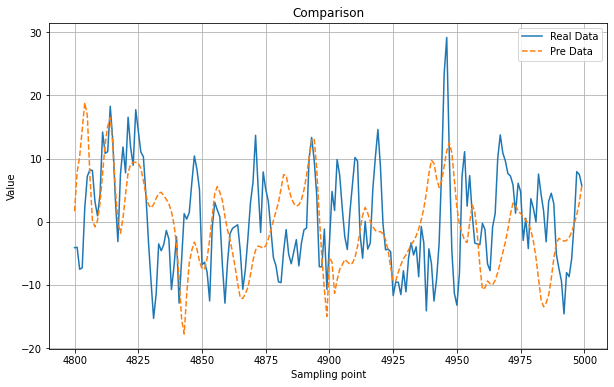

频谱相似度: 0.6284


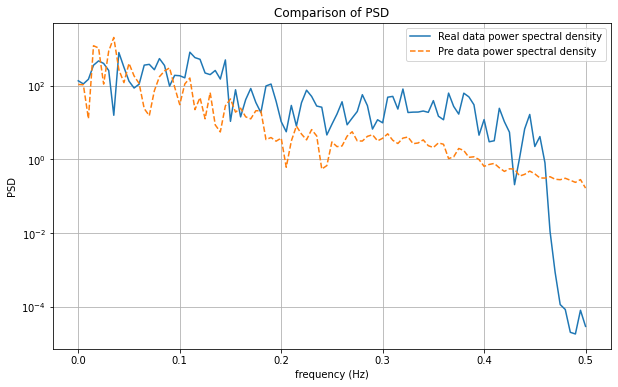

功率谱密度 (PSD) 相似度: 0.3673


In [11]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau
from scipy.signal import welch
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

# 固定随机种子
random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

# 假设已经有 sampled_data 变量包含了 5000 个点的数据
# 数据划分并标准化
scaler = MinMaxScaler(feature_range=(-1, 1))  # 使用 MinMaxScaler 进行标准化
sampled_data = sampled_data[:5000]  # 已经采样好的5000个点
train_data = scaler.fit_transform(sampled_data[:4800].reshape(-1, 1)).reshape(-1)  # 标准化训练数据
test_data = scaler.transform(sampled_data[4800:].reshape(-1, 1)).reshape(-1)  # 标准化测试数据

n_steps = 30  # 调整时间步长，避免过长的时间依赖造成梯度消失
X = []
y = []

# 构建 LSTM 输入，滑动窗口构造样本
for i in range(len(train_data) - n_steps):
    X.append(train_data[i:i+n_steps])
    y.append(train_data[i+n_steps])

X, y = np.array(X), np.array(y)

# 构建 LSTM 模型，加入 BatchNormalization，使用梯度裁剪防止梯度爆炸
model = Sequential()
model.add(LSTM(50, activation='tanh', return_sequences=True, input_shape=(n_steps, 1)))  # 使用tanh激活函数避免梯度消失
model.add(BatchNormalization())  # 批量归一化
model.add(LSTM(50, activation='tanh'))  # 使用tanh激活函数
model.add(BatchNormalization())  # 批量归一化
model.add(Dense(1))  # 输出层

# 使用梯度裁剪，防止梯度爆炸
optimizer = Adam(learning_rate=0.001, clipvalue=1.0, amsgrad=True)  # clipvalue防止梯度爆炸
model.compile(optimizer=optimizer, loss='mse')

# 学习率调度器，随着训练过程逐步降低学习率
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-6)

# 使用 tqdm 进度条
epochs = 200
with tqdm(total=epochs, desc="Training Progress") as pbar:

    def on_epoch_end(epoch, logs):
        pbar.update(1)

    # 创建 LambdaCallback，来在每个 epoch 结束时更新进度条
    progress_callback = LambdaCallback(on_epoch_end=on_epoch_end)

    # 模型训练
    X = X.reshape((X.shape[0], X.shape[1], 1))  # 调整为 LSTM 输入格式
    model.fit(X, y, epochs=epochs, batch_size=32, shuffle=False, verbose=0, callbacks=[progress_callback, lr_scheduler])

# 用模型预测未来 200 个点
X_input = train_data[-n_steps:].reshape((1, n_steps, 1))  # 取最后 30 个点作为输入
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)

    # 检查预测值是否异常，避免 NaN 或 inf
    if np.isnan(predicted) or np.isinf(predicted):
        print(f'Warning: Invalid predicted value at step {_}, setting to 0.')
        predicted[0][0] = 0  # 处理异常值

    predicted_points.append(predicted[0][0])

    # 滑动窗口更新
    predicted_reshaped = np.array(predicted[0][0]).reshape(1, 1, 1)
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)

predicted_points = np.array(predicted_points)  # 将预测结果转换为 NumPy 数组

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_data.reshape(-1, 1)).reshape(-1)

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制预测结果与真实数据的对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data_rescaled, label='Real Data')
plt.plot(range(4800, 5000), predicted_points_rescaled, label='Pre Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
# 对真实值和预测值做 FFT 变换
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)

# 计算余弦相似度
fft_real_abs = np.abs(fft_real).reshape(1, -1)
fft_pred_abs = np.abs(fft_pred).reshape(1, -1)
spectral_similarity = cosine_similarity(fft_real_abs, fft_pred_abs)[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD) 用于频域特征匹配
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)  # Welch 方法计算真实数据的功率谱密度
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)  # 计算预测数据的功率谱密度

# 绘制功率谱密度对比图
plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real data power spectral density')
plt.semilogy(f_pred, psd_pred, label='Pre data power spectral density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算频域特征匹配度 (余弦相似度)
psd_real = psd_real.reshape(1, -1)
psd_pred = psd_pred.reshape(1, -1)
psd_similarity = cosine_similarity(psd_real, psd_pred)[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')


Training Progress: 100%|█████████████████████████████████████████████████████████████| 200/200 [15:58<00:00,  4.79s/it]


均方根误差 (RMSE): 10.6437


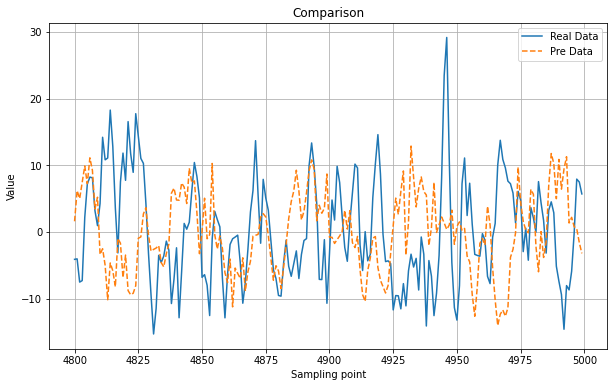

频谱相似度: 0.7650


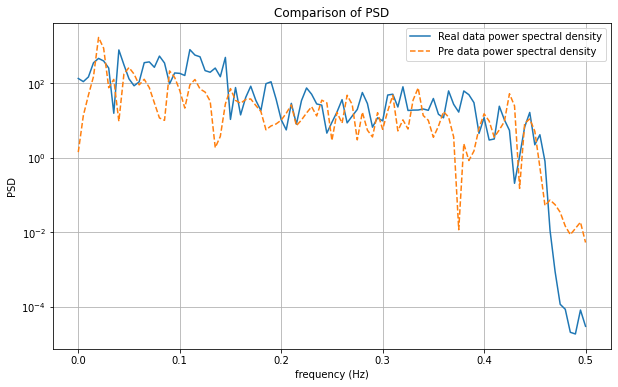

功率谱密度 (PSD) 相似度: 0.4376


In [12]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau
from scipy.signal import welch
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

# 固定随机种子
random.seed(23)
np.random.seed(24)
tf.random.set_seed(25)

# 假设已经有 sampled_data 变量包含了 5000 个点的数据
# 数据划分并标准化
scaler = MinMaxScaler(feature_range=(-1, 1))  # 使用 MinMaxScaler 进行标准化
sampled_data = sampled_data[:5000]  # 已经采样好的5000个点
train_data = scaler.fit_transform(sampled_data[:4800].reshape(-1, 1)).reshape(-1)  # 标准化训练数据
test_data = scaler.transform(sampled_data[4800:].reshape(-1, 1)).reshape(-1)  # 标准化测试数据

n_steps = 30  # 调整时间步长，避免过长的时间依赖造成梯度消失
X = []
y = []

# 构建 LSTM 输入，滑动窗口构造样本
for i in range(len(train_data) - n_steps):
    X.append(train_data[i:i+n_steps])
    y.append(train_data[i+n_steps])

X, y = np.array(X), np.array(y)

# 构建 LSTM 模型，加入 BatchNormalization，使用梯度裁剪防止梯度爆炸
model = Sequential()
model.add(LSTM(50, activation='tanh', return_sequences=True, input_shape=(n_steps, 1)))  # 使用tanh激活函数避免梯度消失
model.add(BatchNormalization())  # 批量归一化
model.add(LSTM(50, activation='tanh'))  # 使用tanh激活函数
model.add(BatchNormalization())  # 批量归一化
model.add(Dense(1))  # 输出层

# 使用梯度裁剪，防止梯度爆炸
optimizer = Adam(learning_rate=0.01, clipvalue=1.0, amsgrad=True)  # clipvalue防止梯度爆炸
model.compile(optimizer=optimizer, loss='mse')

# 学习率调度器，随着训练过程逐步降低学习率
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-6)

# 使用 tqdm 进度条
epochs = 200
with tqdm(total=epochs, desc="Training Progress") as pbar:

    def on_epoch_end(epoch, logs):
        pbar.update(1)

    # 创建 LambdaCallback，来在每个 epoch 结束时更新进度条
    progress_callback = LambdaCallback(on_epoch_end=on_epoch_end)

    # 模型训练
    X = X.reshape((X.shape[0], X.shape[1], 1))  # 调整为 LSTM 输入格式
    model.fit(X, y, epochs=epochs, batch_size=32, shuffle=False, verbose=0, callbacks=[progress_callback, lr_scheduler])

# 用模型预测未来 200 个点
X_input = train_data[-n_steps:].reshape((1, n_steps, 1))  # 取最后 30 个点作为输入
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)

    # 检查预测值是否异常，避免 NaN 或 inf
    if np.isnan(predicted) or np.isinf(predicted):
        print(f'Warning: Invalid predicted value at step {_}, setting to 0.')
        predicted[0][0] = 0  # 处理异常值

    predicted_points.append(predicted[0][0])

    # 滑动窗口更新
    predicted_reshaped = np.array(predicted[0][0]).reshape(1, 1, 1)
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)

predicted_points = np.array(predicted_points)  # 将预测结果转换为 NumPy 数组

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_data.reshape(-1, 1)).reshape(-1)

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制预测结果与真实数据的对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data_rescaled, label='Real Data')
plt.plot(range(4800, 5000), predicted_points_rescaled, label='Pre Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
# 对真实值和预测值做 FFT 变换
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)

# 计算余弦相似度
fft_real_abs = np.abs(fft_real).reshape(1, -1)
fft_pred_abs = np.abs(fft_pred).reshape(1, -1)
spectral_similarity = cosine_similarity(fft_real_abs, fft_pred_abs)[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD) 用于频域特征匹配
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)  # Welch 方法计算真实数据的功率谱密度
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)  # 计算预测数据的功率谱密度

# 绘制功率谱密度对比图
plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real data power spectral density')
plt.semilogy(f_pred, psd_pred, label='Pre data power spectral density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算频域特征匹配度 (余弦相似度)
psd_real = psd_real.reshape(1, -1)
psd_pred = psd_pred.reshape(1, -1)
psd_similarity = cosine_similarity(psd_real, psd_pred)[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')

Training Progress: 100%|█████████████████████████████████████████████████████████████| 200/200 [16:44<00:00,  5.02s/it]


均方根误差 (RMSE): 7.8922


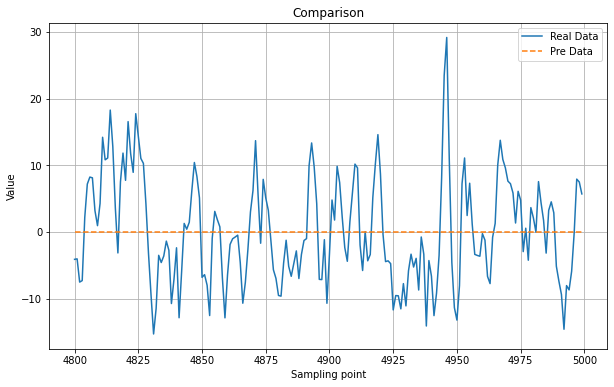

频谱相似度: 0.0271


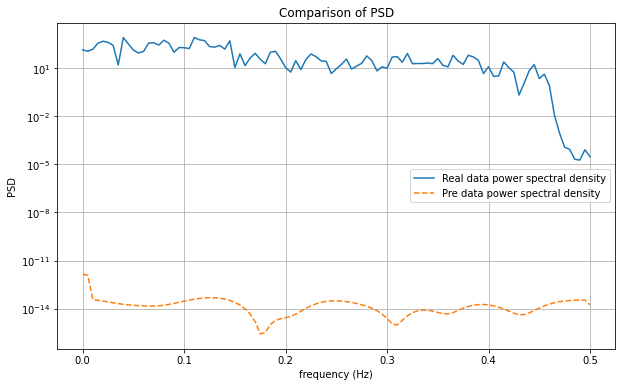

功率谱密度 (PSD) 相似度: 0.0000


In [19]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau
from scipy.signal import welch
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

# 固定随机种子
random.seed(23)
np.random.seed(24)
tf.random.set_seed(25)

# 假设已经有 sampled_data 变量包含了 5000 个点的数据
# 数据划分并标准化
scaler = MinMaxScaler(feature_range=(-1, 1))  # 使用 MinMaxScaler 进行标准化
sampled_data = sampled_data[:5000]  # 已经采样好的5000个点
train_data = scaler.fit_transform(sampled_data[:4800].reshape(-1, 1)).reshape(-1)  # 标准化训练数据
test_data = scaler.transform(sampled_data[4800:].reshape(-1, 1)).reshape(-1)  # 标准化测试数据

n_steps = 30  # 调整时间步长，避免过长的时间依赖造成梯度消失
X = []
y = []

# 构建 LSTM 输入，滑动窗口构造样本
for i in range(len(train_data) - n_steps):
    X.append(train_data[i:i+n_steps])
    y.append(train_data[i+n_steps])

X, y = np.array(X), np.array(y)

# 构建 LSTM 模型，加入 BatchNormalization，使用梯度裁剪防止梯度爆炸
model = Sequential()
model.add(LSTM(50, activation='tanh', return_sequences=True, input_shape=(n_steps, 1)))  # 使用tanh激活函数避免梯度消失
model.add(BatchNormalization())  # 批量归一化
model.add(LSTM(50, activation='tanh'))  # 使用tanh激活函数
model.add(BatchNormalization())  # 批量归一化
model.add(Dense(1))  # 输出层

# 使用梯度裁剪，防止梯度爆炸
optimizer = Adam(learning_rate=0.1, clipvalue=1.0, amsgrad=True)  # clipvalue防止梯度爆炸
model.compile(optimizer=optimizer, loss='mse')

# 学习率调度器，随着训练过程逐步降低学习率
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-4)

# 使用 tqdm 进度条
epochs = 200
with tqdm(total=epochs, desc="Training Progress") as pbar:

    def on_epoch_end(epoch, logs):
        pbar.update(1)

    # 创建 LambdaCallback，来在每个 epoch 结束时更新进度条
    progress_callback = LambdaCallback(on_epoch_end=on_epoch_end)

    # 模型训练
    X = X.reshape((X.shape[0], X.shape[1], 1))  # 调整为 LSTM 输入格式
    model.fit(X, y, epochs=epochs, batch_size=32, shuffle=False, verbose=0, callbacks=[progress_callback, lr_scheduler])

# 用模型预测未来 200 个点
X_input = train_data[-n_steps:].reshape((1, n_steps, 1))  # 取最后 30 个点作为输入
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)

    # 检查预测值是否异常，避免 NaN 或 inf
    if np.isnan(predicted) or np.isinf(predicted):
        print(f'Warning: Invalid predicted value at step {_}, setting to 0.')
        predicted[0][0] = 0  # 处理异常值

    predicted_points.append(predicted[0][0])

    # 滑动窗口更新
    predicted_reshaped = np.array(predicted[0][0]).reshape(1, 1, 1)
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)

predicted_points = np.array(predicted_points)  # 将预测结果转换为 NumPy 数组

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_data.reshape(-1, 1)).reshape(-1)

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制预测结果与真实数据的对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data_rescaled, label='Real Data')
plt.plot(range(4800, 5000), predicted_points_rescaled, label='Pre Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
# 对真实值和预测值做 FFT 变换
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)

# 计算余弦相似度
fft_real_abs = np.abs(fft_real).reshape(1, -1)
fft_pred_abs = np.abs(fft_pred).reshape(1, -1)
spectral_similarity = cosine_similarity(fft_real_abs, fft_pred_abs)[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD) 用于频域特征匹配
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)  # Welch 方法计算真实数据的功率谱密度
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)  # 计算预测数据的功率谱密度

# 绘制功率谱密度对比图
plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real data power spectral density')
plt.semilogy(f_pred, psd_pred, label='Pre data power spectral density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算频域特征匹配度 (余弦相似度)
psd_real = psd_real.reshape(1, -1)
psd_pred = psd_pred.reshape(1, -1)
psd_similarity = cosine_similarity(psd_real, psd_pred)[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')

Training Progress: 100%|█████████████████████████████████████████████████████████████| 200/200 [16:32<00:00,  4.96s/it]


均方根误差 (RMSE): 9.7483


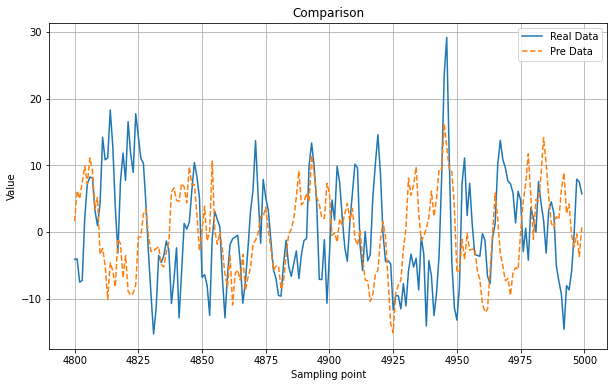

频谱相似度: 0.7807


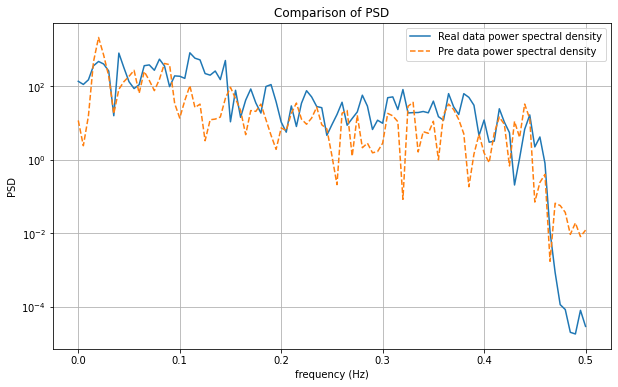

功率谱密度 (PSD) 相似度: 0.4694


In [18]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau
from scipy.signal import welch
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

# 固定随机种子
random.seed(23)
np.random.seed(24)
tf.random.set_seed(25)

# 假设已经有 sampled_data 变量包含了 5000 个点的数据
# 数据划分并标准化
scaler = MinMaxScaler(feature_range=(-1, 1))  # 使用 MinMaxScaler 进行标准化
sampled_data = sampled_data[:5000]  # 已经采样好的5000个点
train_data = scaler.fit_transform(sampled_data[:4800].reshape(-1, 1)).reshape(-1)  # 标准化训练数据
test_data = scaler.transform(sampled_data[4800:].reshape(-1, 1)).reshape(-1)  # 标准化测试数据

n_steps = 30  # 调整时间步长，避免过长的时间依赖造成梯度消失
X = []
y = []

# 构建 LSTM 输入，滑动窗口构造样本
for i in range(len(train_data) - n_steps):
    X.append(train_data[i:i+n_steps])
    y.append(train_data[i+n_steps])

X, y = np.array(X), np.array(y)

# 构建 LSTM 模型，加入 BatchNormalization，使用梯度裁剪防止梯度爆炸
model = Sequential()
model.add(LSTM(50, activation='tanh', return_sequences=True, input_shape=(n_steps, 1)))  # 使用tanh激活函数避免梯度消失
model.add(BatchNormalization())  # 批量归一化
model.add(LSTM(50, activation='tanh'))  # 使用tanh激活函数
model.add(BatchNormalization())  # 批量归一化
model.add(Dense(1))  # 输出层

# 使用梯度裁剪，防止梯度爆炸
optimizer = Adam(learning_rate=0.01, clipvalue=1.0, amsgrad=True)  # clipvalue防止梯度爆炸
model.compile(optimizer=optimizer, loss='mse')

# 学习率调度器，随着训练过程逐步降低学习率
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-4)

# 使用 tqdm 进度条
epochs = 200
with tqdm(total=epochs, desc="Training Progress") as pbar:

    def on_epoch_end(epoch, logs):
        pbar.update(1)

    # 创建 LambdaCallback，来在每个 epoch 结束时更新进度条
    progress_callback = LambdaCallback(on_epoch_end=on_epoch_end)

    # 模型训练
    X = X.reshape((X.shape[0], X.shape[1], 1))  # 调整为 LSTM 输入格式
    model.fit(X, y, epochs=epochs, batch_size=32, shuffle=False, verbose=0, callbacks=[progress_callback, lr_scheduler])

# 用模型预测未来 200 个点
X_input = train_data[-n_steps:].reshape((1, n_steps, 1))  # 取最后 30 个点作为输入
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)

    # 检查预测值是否异常，避免 NaN 或 inf
    if np.isnan(predicted) or np.isinf(predicted):
        print(f'Warning: Invalid predicted value at step {_}, setting to 0.')
        predicted[0][0] = 0  # 处理异常值

    predicted_points.append(predicted[0][0])

    # 滑动窗口更新
    predicted_reshaped = np.array(predicted[0][0]).reshape(1, 1, 1)
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)

predicted_points = np.array(predicted_points)  # 将预测结果转换为 NumPy 数组

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_data.reshape(-1, 1)).reshape(-1)

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制预测结果与真实数据的对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data_rescaled, label='Real Data')
plt.plot(range(4800, 5000), predicted_points_rescaled, label='Pre Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
# 对真实值和预测值做 FFT 变换
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)

# 计算余弦相似度
fft_real_abs = np.abs(fft_real).reshape(1, -1)
fft_pred_abs = np.abs(fft_pred).reshape(1, -1)
spectral_similarity = cosine_similarity(fft_real_abs, fft_pred_abs)[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD) 用于频域特征匹配
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)  # Welch 方法计算真实数据的功率谱密度
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)  # 计算预测数据的功率谱密度

# 绘制功率谱密度对比图
plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real data power spectral density')
plt.semilogy(f_pred, psd_pred, label='Pre data power spectral density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算频域特征匹配度 (余弦相似度)
psd_real = psd_real.reshape(1, -1)
psd_pred = psd_pred.reshape(1, -1)
psd_similarity = cosine_similarity(psd_real, psd_pred)[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')

Training Progress: 100%|█████████████████████████████████████████████████████████████| 200/200 [16:07<00:00,  4.84s/it]


均方根误差 (RMSE): 10.6437


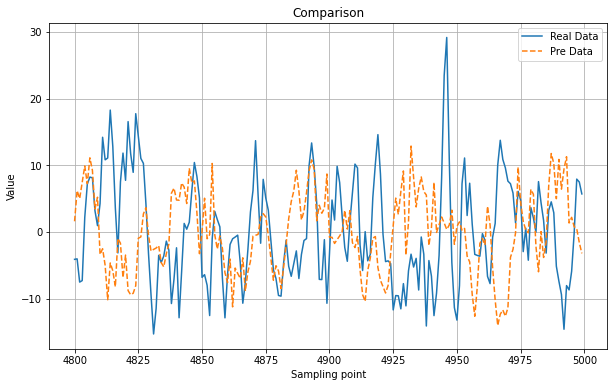

频谱相似度: 0.7650


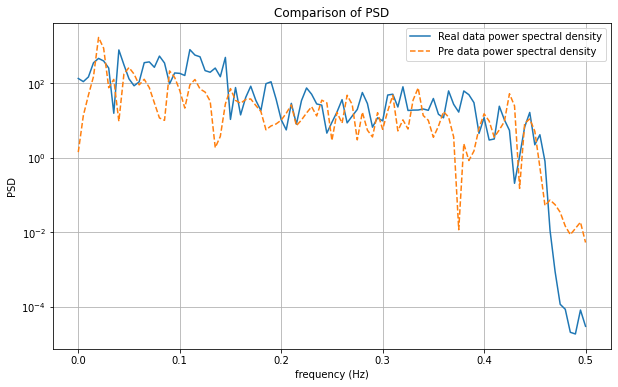

功率谱密度 (PSD) 相似度: 0.4376


In [20]:
 import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau
from scipy.signal import welch
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

# 固定随机种子
random.seed(23)
np.random.seed(24)
tf.random.set_seed(25)

# 假设已经有 sampled_data 变量包含了 5000 个点的数据
# 数据划分并标准化
scaler = MinMaxScaler(feature_range=(-1, 1))  # 使用 MinMaxScaler 进行标准化
sampled_data = sampled_data[:5000]  # 已经采样好的5000个点
train_data = scaler.fit_transform(sampled_data[:4800].reshape(-1, 1)).reshape(-1)  # 标准化训练数据
test_data = scaler.transform(sampled_data[4800:].reshape(-1, 1)).reshape(-1)  # 标准化测试数据

n_steps = 30  # 调整时间步长，避免过长的时间依赖造成梯度消失
X = []
y = []

# 构建 LSTM 输入，滑动窗口构造样本
for i in range(len(train_data) - n_steps):
    X.append(train_data[i:i+n_steps])
    y.append(train_data[i+n_steps])

X, y = np.array(X), np.array(y)

# 构建 LSTM 模型，加入 BatchNormalization，使用梯度裁剪防止梯度爆炸
model = Sequential()
model.add(LSTM(50, activation='tanh', return_sequences=True, input_shape=(n_steps, 1)))  # 使用tanh激活函数避免梯度消失
model.add(BatchNormalization())  # 批量归一化
model.add(LSTM(50, activation='tanh'))  # 使用tanh激活函数
model.add(BatchNormalization())  # 批量归一化
model.add(Dense(1))  # 输出层

# 使用梯度裁剪，防止梯度爆炸
optimizer = Adam(learning_rate=0.01, clipvalue=1.0, amsgrad=True)  # clipvalue防止梯度爆炸
model.compile(optimizer=optimizer, loss='mse')

# 学习率调度器，随着训练过程逐步降低学习率
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-5)

# 使用 tqdm 进度条
epochs = 200
with tqdm(total=epochs, desc="Training Progress") as pbar:

    def on_epoch_end(epoch, logs):
        pbar.update(1)

    # 创建 LambdaCallback，来在每个 epoch 结束时更新进度条
    progress_callback = LambdaCallback(on_epoch_end=on_epoch_end)

    # 模型训练
    X = X.reshape((X.shape[0], X.shape[1], 1))  # 调整为 LSTM 输入格式
    model.fit(X, y, epochs=epochs, batch_size=32, shuffle=False, verbose=0, callbacks=[progress_callback, lr_scheduler])

# 用模型预测未来 200 个点
X_input = train_data[-n_steps:].reshape((1, n_steps, 1))  # 取最后 30 个点作为输入
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)

    # 检查预测值是否异常，避免 NaN 或 inf
    if np.isnan(predicted) or np.isinf(predicted):
        print(f'Warning: Invalid predicted value at step {_}, setting to 0.')
        predicted[0][0] = 0  # 处理异常值

    predicted_points.append(predicted[0][0])

    # 滑动窗口更新
    predicted_reshaped = np.array(predicted[0][0]).reshape(1, 1, 1)
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)

predicted_points = np.array(predicted_points)  # 将预测结果转换为 NumPy 数组

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_data.reshape(-1, 1)).reshape(-1)

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制预测结果与真实数据的对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data_rescaled, label='Real Data')
plt.plot(range(4800, 5000), predicted_points_rescaled, label='Pre Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
# 对真实值和预测值做 FFT 变换
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)

# 计算余弦相似度
fft_real_abs = np.abs(fft_real).reshape(1, -1)
fft_pred_abs = np.abs(fft_pred).reshape(1, -1)
spectral_similarity = cosine_similarity(fft_real_abs, fft_pred_abs)[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD) 用于频域特征匹配
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)  # Welch 方法计算真实数据的功率谱密度
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)  # 计算预测数据的功率谱密度

# 绘制功率谱密度对比图
plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real data power spectral density')
plt.semilogy(f_pred, psd_pred, label='Pre data power spectral density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算频域特征匹配度 (余弦相似度)
psd_real = psd_real.reshape(1, -1)
psd_pred = psd_pred.reshape(1, -1)
psd_similarity = cosine_similarity(psd_real, psd_pred)[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')

Training Progress: 100%|█████████████████████████████████████████████████████████████| 200/200 [09:10<00:00,  2.75s/it]


均方根误差 (RMSE): 10.6437


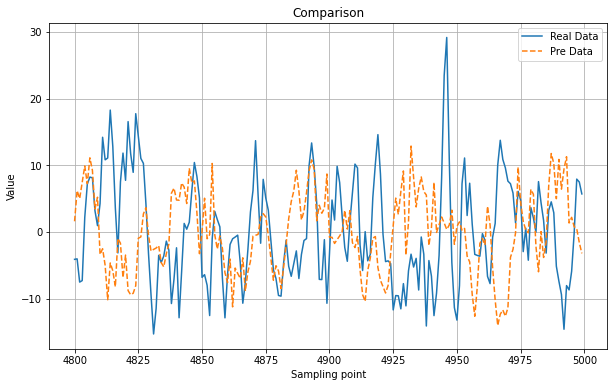

频谱相似度: 0.7650


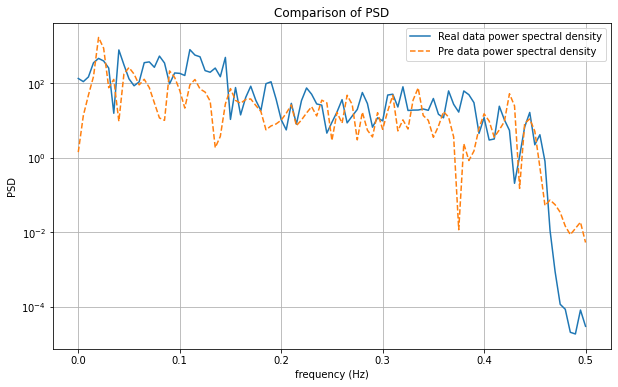

功率谱密度 (PSD) 相似度: 0.4376


In [4]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau
from scipy.signal import welch
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

# 固定随机种子
random.seed(23)
np.random.seed(24)
tf.random.set_seed(25)

# 假设已经有 sampled_data 变量包含了 5000 个点的数据
# 数据划分并标准化
scaler = MinMaxScaler(feature_range=(-1, 1))  # 使用 MinMaxScaler 进行标准化
sampled_data = sampled_data[:5000]  # 已经采样好的5000个点
train_data = scaler.fit_transform(sampled_data[:4800].reshape(-1, 1)).reshape(-1)  # 标准化训练数据
test_data = scaler.transform(sampled_data[4800:].reshape(-1, 1)).reshape(-1)  # 标准化测试数据

n_steps = 30  # 调整时间步长，避免过长的时间依赖造成梯度消失
X = []
y = []

# 构建 LSTM 输入，滑动窗口构造样本
for i in range(len(train_data) - n_steps):
    X.append(train_data[i:i+n_steps])
    y.append(train_data[i+n_steps])

X, y = np.array(X), np.array(y)

# 构建 LSTM 模型，加入 BatchNormalization，使用梯度裁剪防止梯度爆炸
model = Sequential()
model.add(LSTM(50, activation='tanh', return_sequences=True, input_shape=(n_steps, 1)))  # 使用tanh激活函数避免梯度消失
model.add(BatchNormalization())  # 批量归一化
model.add(LSTM(50, activation='tanh'))  # 使用tanh激活函数
model.add(BatchNormalization())  # 批量归一化
model.add(Dense(1))  # 输出层

# 使用梯度裁剪，防止梯度爆炸
optimizer = Adam(learning_rate=0.01, clipvalue=1.0, amsgrad=True)  # clipvalue防止梯度爆炸
model.compile(optimizer=optimizer, loss='mse')

# 学习率调度器，随着训练过程逐步降低学习率
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-5)

# 使用 tqdm 进度条
epochs = 200
with tqdm(total=epochs, desc="Training Progress") as pbar:

    def on_epoch_end(epoch, logs):
        pbar.update(1)

    # 创建 LambdaCallback，来在每个 epoch 结束时更新进度条
    progress_callback = LambdaCallback(on_epoch_end=on_epoch_end)

    # 模型训练
    X = X.reshape((X.shape[0], X.shape[1], 1))  # 调整为 LSTM 输入格式
    model.fit(X, y, epochs=epochs, batch_size=32, shuffle=False, verbose=0, callbacks=[progress_callback, lr_scheduler])

# 用模型预测未来 200 个点
X_input = train_data[-n_steps:].reshape((1, n_steps, 1))  # 取最后 30 个点作为输入
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)

    # 检查预测值是否异常，避免 NaN 或 inf
    if np.isnan(predicted) or np.isinf(predicted):
        print(f'Warning: Invalid predicted value at step {_}, setting to 0.')
        predicted[0][0] = 0  # 处理异常值

    predicted_points.append(predicted[0][0])

    # 滑动窗口更新
    predicted_reshaped = np.array(predicted[0][0]).reshape(1, 1, 1)
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)

predicted_points = np.array(predicted_points)  # 将预测结果转换为 NumPy 数组

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_data.reshape(-1, 1)).reshape(-1)

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制预测结果与真实数据的对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data_rescaled, label='Real Data')
plt.plot(range(4800, 5000), predicted_points_rescaled, label='Pre Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
# 对真实值和预测值做 FFT 变换
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)

# 计算余弦相似度
fft_real_abs = np.abs(fft_real).reshape(1, -1)
fft_pred_abs = np.abs(fft_pred).reshape(1, -1)
spectral_similarity = cosine_similarity(fft_real_abs, fft_pred_abs)[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD) 用于频域特征匹配
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)  # Welch 方法计算真实数据的功率谱密度
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)  # 计算预测数据的功率谱密度

# 绘制功率谱密度对比图
plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real data power spectral density')
plt.semilogy(f_pred, psd_pred, label='Pre data power spectral density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算频域特征匹配度 (余弦相似度)
psd_real = psd_real.reshape(1, -1)
psd_pred = psd_pred.reshape(1, -1)
psd_similarity = cosine_similarity(psd_real, psd_pred)[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')

Training Progress: 100%|█████████████████████████████████████████████████████████████| 200/200 [13:18<00:00,  3.99s/it]


均方根误差 (RMSE): 7.9415


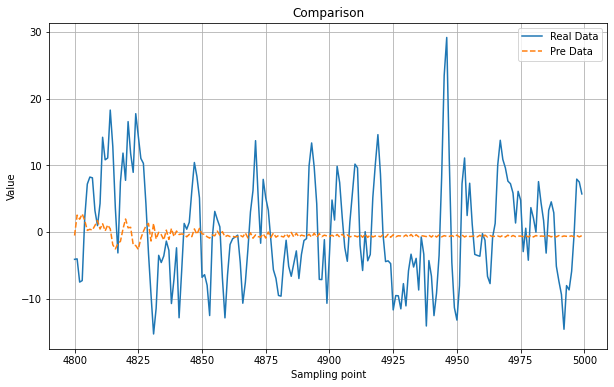

频谱相似度: 0.6790


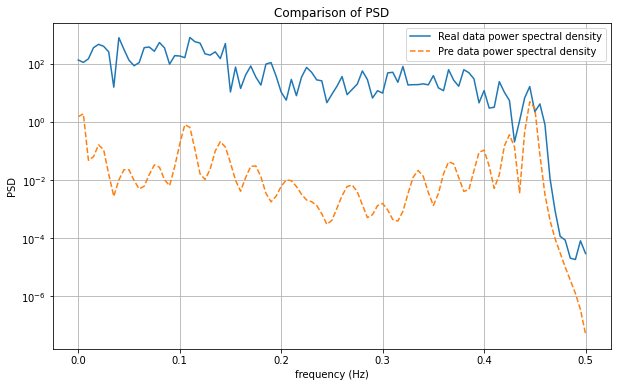

功率谱密度 (PSD) 相似度: 0.1278


In [6]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau
from scipy.signal import welch
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

# 固定随机种子
random.seed(23)
np.random.seed(24)
tf.random.set_seed(25)

# 假设已经有 sampled_data 变量包含了 5000 个点的数据
# 数据划分并标准化
scaler = MinMaxScaler(feature_range=(-1, 1))  # 使用 MinMaxScaler 进行标准化
sampled_data = sampled_data[:5000]  # 已经采样好的5000个点
train_data = scaler.fit_transform(sampled_data[:4800].reshape(-1, 1)).reshape(-1)  # 标准化训练数据
test_data = scaler.transform(sampled_data[4800:].reshape(-1, 1)).reshape(-1)  # 标准化测试数据

n_steps = 30  # 调整时间步长，避免过长的时间依赖造成梯度消失
X = []
y = []

# 构建 LSTM 输入，滑动窗口构造样本
for i in range(len(train_data) - n_steps):
    X.append(train_data[i:i+n_steps])
    y.append(train_data[i+n_steps])

X, y = np.array(X), np.array(y)

# 构建 LSTM 模型，加入 BatchNormalization，使用梯度裁剪防止梯度爆炸
model = Sequential()
model.add(LSTM(50, activation='tanh', return_sequences=True, input_shape=(n_steps, 1)))  # 使用tanh激活函数避免梯度消失
model.add(BatchNormalization())  # 批量归一化
model.add(LSTM(50, activation='tanh'))  # 使用tanh激活函数
model.add(BatchNormalization())  # 批量归一化
model.add(Dense(1))  # 输出层

# 使用梯度裁剪，防止梯度爆炸
optimizer = Adam(learning_rate=0.05, clipvalue=1.0, amsgrad=True)  # clipvalue防止梯度爆炸
model.compile(optimizer=optimizer, loss='mse')

# 学习率调度器，随着训练过程逐步降低学习率
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-6)

# 使用 tqdm 进度条
epochs = 200
with tqdm(total=epochs, desc="Training Progress") as pbar:

    def on_epoch_end(epoch, logs):
        pbar.update(1)

    # 创建 LambdaCallback，来在每个 epoch 结束时更新进度条
    progress_callback = LambdaCallback(on_epoch_end=on_epoch_end)

    # 模型训练
    X = X.reshape((X.shape[0], X.shape[1], 1))  # 调整为 LSTM 输入格式
    model.fit(X, y, epochs=epochs, batch_size=32, shuffle=False, verbose=0, callbacks=[progress_callback, lr_scheduler])

# 用模型预测未来 200 个点
X_input = train_data[-n_steps:].reshape((1, n_steps, 1))  # 取最后 30 个点作为输入
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)

    # 检查预测值是否异常，避免 NaN 或 inf
    if np.isnan(predicted) or np.isinf(predicted):
        print(f'Warning: Invalid predicted value at step {_}, setting to 0.')
        predicted[0][0] = 0  # 处理异常值

    predicted_points.append(predicted[0][0])

    # 滑动窗口更新
    predicted_reshaped = np.array(predicted[0][0]).reshape(1, 1, 1)
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)

predicted_points = np.array(predicted_points)  # 将预测结果转换为 NumPy 数组

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_data.reshape(-1, 1)).reshape(-1)

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制预测结果与真实数据的对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data_rescaled, label='Real Data')
plt.plot(range(4800, 5000), predicted_points_rescaled, label='Pre Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
# 对真实值和预测值做 FFT 变换
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)

# 计算余弦相似度
fft_real_abs = np.abs(fft_real).reshape(1, -1)
fft_pred_abs = np.abs(fft_pred).reshape(1, -1)
spectral_similarity = cosine_similarity(fft_real_abs, fft_pred_abs)[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD) 用于频域特征匹配
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)  # Welch 方法计算真实数据的功率谱密度
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)  # 计算预测数据的功率谱密度

# 绘制功率谱密度对比图
plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real data power spectral density')
plt.semilogy(f_pred, psd_pred, label='Pre data power spectral density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算频域特征匹配度 (余弦相似度)
psd_real = psd_real.reshape(1, -1)
psd_pred = psd_pred.reshape(1, -1)
psd_similarity = cosine_similarity(psd_real, psd_pred)[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')

In [8]:
data = scio.loadmat('C:/Users/Brilliant/Desktop/data.mat')
matrix_data = data['data']
# 提取第一行（第一通道的EEG数据）
first_channel = matrix_data[0, :]
sampled_data = first_channel[:50000:10]
len(sampled_data)

5000

Epoch 1/200
118/118 [==============================] - ETA: 0s - loss: 0.2951
Epoch 1: val_loss improved from inf to 0.24048, saving model to best_model.h5
118/118 [==============================] - 34s 218ms/step - loss: 0.2951 - val_loss: 0.2405
Epoch 2/200
118/118 [==============================] - ETA: 0s - loss: 0.2060
Epoch 2: val_loss improved from 0.24048 to 0.18872, saving model to best_model.h5
118/118 [==============================] - 24s 201ms/step - loss: 0.2060 - val_loss: 0.1887
Epoch 3/200
118/118 [==============================] - ETA: 0s - loss: 0.1637
Epoch 3: val_loss improved from 0.18872 to 0.17926, saving model to best_model.h5
118/118 [==============================] - 24s 203ms/step - loss: 0.1637 - val_loss: 0.1793
Epoch 4/200
118/118 [==============================] - ETA: 0s - loss: 0.1374
Epoch 4: val_loss did not improve from 0.17926
118/118 [==============================] - 21s 182ms/step - loss: 0.1374 - val_loss: 0.2802
Epoch 5/200
118/118 [==========

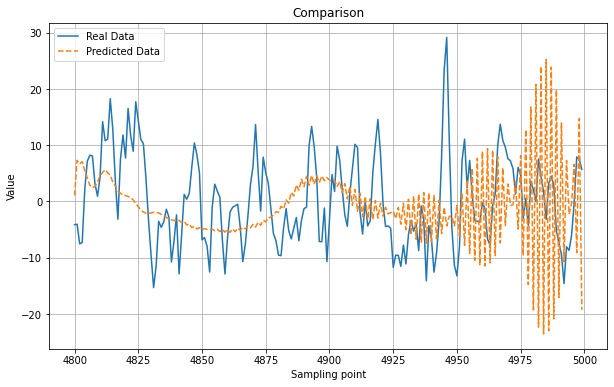

频谱相似度: 0.2917


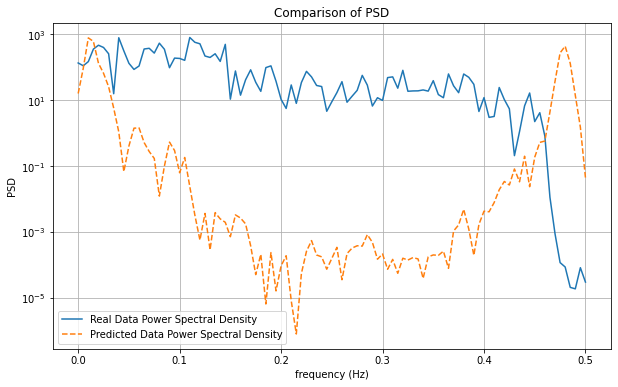

功率谱密度 (PSD) 相似度: 0.1939


In [9]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Input, LSTM, Dropout
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from scipy.signal import welch
from sklearn.preprocessing import MinMaxScaler

# 固定随机种子
random.seed(23)
np.random.seed(24)
tf.random.set_seed(25)

# 数据归一化
scaler = MinMaxScaler(feature_range=(-1, 1))  
sampled_data = sampled_data[:5000]
train_data = scaler.fit_transform(sampled_data[:4800].reshape(-1, 1)).reshape(-1)
test_data = scaler.transform(sampled_data[4800:].reshape(-1, 1)).reshape(-1)

n_steps = 90  # 时间步长
X, y = [], []

for i in range(len(train_data) - n_steps):
    X.append(train_data[i:i+n_steps])
    y.append(train_data[i+n_steps])

X, y = np.array(X), np.array(y)

# 构建双层 LSTM 模型，添加 L2 正则化和 Dropout
def build_lstm_model(input_shape, units, dropout=0.2, l2_reg=0.001):
    inputs = Input(shape=input_shape)
    x = LSTM(units, return_sequences=True, kernel_regularizer=l2(l2_reg))(inputs)  # 第一层 LSTM
    x = LSTM(units, kernel_regularizer=l2(l2_reg))(x)                             # 第二层 LSTM
    x = BatchNormalization()(x)
    x = Dense(64, activation="relu", kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropout)(x)
    x = Dense(1, kernel_regularizer=l2(l2_reg))(x)
    model = Model(inputs, x)
    return model

# 自定义损失函数结合频谱相似度
def custom_loss(y_true, y_pred):
    mse_loss = K.mean(K.square(y_pred - y_true))
    fft_true = tf.signal.fft(tf.cast(y_true, tf.complex64))
    fft_pred = tf.signal.fft(tf.cast(y_pred, tf.complex64))
    fft_true_abs = tf.abs(fft_true)
    fft_pred_abs = tf.abs(fft_pred)
    spectral_loss = K.mean(K.square(fft_true_abs - fft_pred_abs))
    return mse_loss + 0.05 * spectral_loss  # 减少频谱相似度的权重

# 构建模型
model = build_lstm_model((n_steps, 1), units=128, dropout=0.2, l2_reg=0.001)

# 使用 Nadam 优化器（固定较小的学习率）
optimizer = Nadam(learning_rate=0.0003)

# 编译模型
model.compile(optimizer=optimizer, loss=custom_loss)

# 学习率调度器和早停机制
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.h5',   # 保存模型的路径
    monitor='val_loss',         # 监控验证损失
    save_best_only=True,        # 仅保存验证集上表现最好的模型
    mode='min',                 # 寻找最小的 val_loss
    verbose=1                   # 每次保存时打印提示
)

# 使用固定的验证集来训练和监控
X_val, y_val = X[:960], y[:960]  # 前 20% 作为验证集
X_train, y_train = X[960:], y[960:]

# 模型训练
epochs = 200
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))  # 调整为 LSTM 输入格式
history = model.fit(
    X_train, y_train, 
    validation_data=(X_val, y_val),
    epochs=epochs, 
    batch_size=32, 
    shuffle=False, 
    verbose=1, 
    callbacks=[early_stopping, checkpoint_callback]
)

# 用模型预测未来 200 个点
X_input = train_data[-n_steps:].reshape((1, n_steps, 1))  # 取最后 90 个点作为输入
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)

    # 检查预测值是否异常，避免 NaN 或 inf
    if np.isnan(predicted).any() or np.isinf(predicted).any():
        print(f'Warning: Invalid predicted value at step {_}, setting to 0.')
        predicted[0][0] = 0  # 处理异常值

    predicted_points.append(predicted[0][0])

    # 滑动窗口更新
    predicted_reshaped = np.array(predicted[0][0]).reshape(1, 1, 1)
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)

predicted_points = np.array(predicted_points)  # 将预测结果转换为 NumPy 数组

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_data.reshape(-1, 1)).reshape(-1)

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制预测结果与真实数据的对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data_rescaled, label='Real Data')
plt.plot(range(4800, 5000), predicted_points_rescaled, label='Predicted Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)

fft_real_abs = np.abs(fft_real).reshape(1, -1)
fft_pred_abs = np.abs(fft_pred).reshape(1, -1)
spectral_similarity = cosine_similarity(fft_real_abs, fft_pred_abs)[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD)
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)  # Welch 方法计算真实数据的功率谱密度
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)  # 计算预测数据的功率谱密度

plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real Data Power Spectral Density')
plt.semilogy(f_pred, psd_pred, label='Predicted Data Power Spectral Density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算频域特征匹配度 (余弦相似度)
psd_real = psd_real.reshape(1, -1)
psd_pred = psd_pred.reshape(1, -1)
psd_similarity = cosine_similarity(psd_real, psd_pred)[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')


# 嵌套双层lstm with早停正则化

Epoch 1/200
118/118 [==============================] - 31s 196ms/step - loss: 0.2951 - val_loss: 0.2405 - lr: 3.0000e-04
Epoch 2/200
118/118 [==============================] - 22s 189ms/step - loss: 0.2060 - val_loss: 0.1887 - lr: 3.0000e-04
Epoch 3/200
118/118 [==============================] - 22s 187ms/step - loss: 0.1637 - val_loss: 0.1793 - lr: 3.0000e-04
Epoch 4/200
118/118 [==============================] - 23s 193ms/step - loss: 0.1374 - val_loss: 0.2802 - lr: 3.0000e-04
Epoch 5/200
118/118 [==============================] - 24s 204ms/step - loss: 0.1231 - val_loss: 0.1378 - lr: 3.0000e-04
Epoch 6/200
118/118 [==============================] - 22s 190ms/step - loss: 0.1130 - val_loss: 0.1289 - lr: 3.0000e-04
Epoch 7/200
118/118 [==============================] - 21s 181ms/step - loss: 0.1042 - val_loss: 0.0915 - lr: 3.0000e-04
Epoch 8/200
118/118 [==============================] - 21s 181ms/step - loss: 0.0963 - val_loss: 0.1213 - lr: 3.0000e-04
Epoch 9/200
118/118 [===========

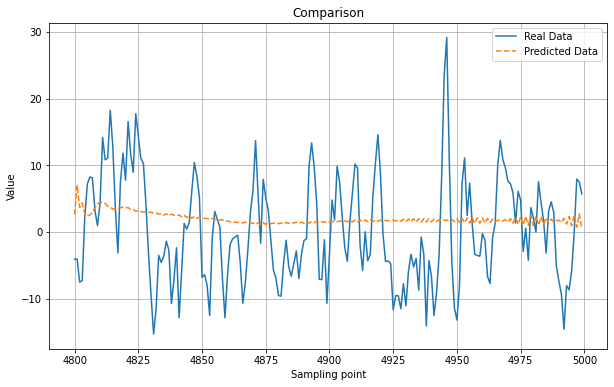

频谱相似度: 0.2777


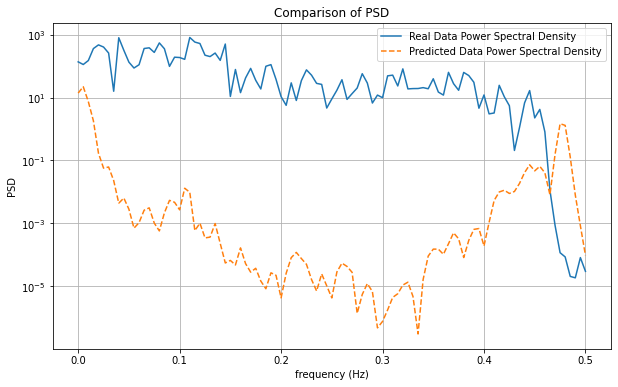

功率谱密度 (PSD) 相似度: 0.1141


In [12]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Input, LSTM, Dropout
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from scipy.signal import welch
from sklearn.preprocessing import MinMaxScaler

# 固定随机种子
random.seed(23)
np.random.seed(24)
tf.random.set_seed(25)

# 数据归一化
scaler = MinMaxScaler(feature_range=(-1, 1))  
sampled_data = sampled_data[:5000]
train_data = scaler.fit_transform(sampled_data[:4800].reshape(-1, 1)).reshape(-1)
test_data = scaler.transform(sampled_data[4800:].reshape(-1, 1)).reshape(-1)

n_steps = 90  # 时间步长
X, y = [], []

for i in range(len(train_data) - n_steps):
    X.append(train_data[i:i+n_steps])
    y.append(train_data[i+n_steps])

X, y = np.array(X), np.array(y)

# 构建双层 LSTM 模型，添加 L2 正则化和 Dropout
def build_lstm_model(input_shape, units, dropout=0.2, l2_reg=0.001):
    inputs = Input(shape=input_shape)
    x = LSTM(units, return_sequences=True, kernel_regularizer=l2(l2_reg))(inputs)  # 第一层 LSTM
    x = LSTM(units, kernel_regularizer=l2(l2_reg))(x)                             # 第二层 LSTM
    x = BatchNormalization()(x)
    x = Dense(64, activation="relu", kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropout)(x)
    x = Dense(1, kernel_regularizer=l2(l2_reg))(x)
    model = Model(inputs, x)
    return model

# 自定义损失函数结合频谱相似度
def custom_loss(y_true, y_pred):
    mse_loss = K.mean(K.square(y_pred - y_true))
    fft_true = tf.signal.fft(tf.cast(y_true, tf.complex64))
    fft_pred = tf.signal.fft(tf.cast(y_pred, tf.complex64))
    fft_true_abs = tf.abs(fft_true)
    fft_pred_abs = tf.abs(fft_pred)
    spectral_loss = K.mean(K.square(fft_true_abs - fft_pred_abs))
    return mse_loss + 0.05 * spectral_loss  # 减少频谱相似度的权重

# 构建模型
model = build_lstm_model((n_steps, 1), units=128, dropout=0.2, l2_reg=0.001)

# 使用 Nadam 优化器（固定较小的学习率）
optimizer = Nadam(learning_rate=0.0003)

# 编译模型
model.compile(optimizer=optimizer, loss=custom_loss)

# 学习率调度器和早停机制
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6, verbose=1)

# 使用固定的验证集来训练和监控
X_val, y_val = X[:960], y[:960]  # 前 20% 作为验证集
X_train, y_train = X[960:], y[960:]

# 模型训练
epochs = 200
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))  # 调整为 LSTM 输入格式
history = model.fit(
    X_train, y_train, 
    validation_data=(X_val, y_val),
    epochs=epochs, 
    batch_size=32, 
    shuffle=False, 
    verbose=1, 
    callbacks=[early_stopping, lr_scheduler]
)

# 用模型预测未来 200 个点
X_input = train_data[-n_steps:].reshape((1, n_steps, 1))  # 取最后 90 个点作为输入
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)

    # 检查预测值是否异常，避免 NaN 或 inf
    if np.isnan(predicted).any() or np.isinf(predicted).any():
        print(f'Warning: Invalid predicted value at step {_}, setting to 0.')
        predicted[0][0] = 0  # 处理异常值

    predicted_points.append(predicted[0][0])

    # 滑动窗口更新
    predicted_reshaped = np.array(predicted[0][0]).reshape(1, 1, 1)
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)

predicted_points = np.array(predicted_points)  # 将预测结果转换为 NumPy 数组

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_data.reshape(-1, 1)).reshape(-1)

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制预测结果与真实数据的对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data_rescaled, label='Real Data')
plt.plot(range(4800, 5000), predicted_points_rescaled, label='Predicted Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)

fft_real_abs = np.abs(fft_real).reshape(1, -1)
fft_pred_abs = np.abs(fft_pred).reshape(1, -1)
spectral_similarity = cosine_similarity(fft_real_abs, fft_pred_abs)[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD)
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)  # Welch 方法计算真实数据的功率谱密度
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)  # 计算预测数据的功率谱密度

plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real Data Power Spectral Density')
plt.semilogy(f_pred, psd_pred, label='Predicted Data Power Spectral Density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算频域特征匹配度 (余弦相似度)
psd_real = psd_real.reshape(1, -1)
psd_pred = psd_pred.reshape(1, -1)
psd_similarity = cosine_similarity(psd_real, psd_pred)[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')


## 双层lstm 不带正则化

Epoch 1/200
118/118 [==============================] - 33s 212ms/step - loss: 0.0642 - val_loss: 0.0649 - lr: 3.0000e-04
Epoch 2/200
118/118 [==============================] - 23s 196ms/step - loss: 0.0518 - val_loss: 0.0679 - lr: 3.0000e-04
Epoch 3/200
118/118 [==============================] - 23s 194ms/step - loss: 0.0415 - val_loss: 0.0705 - lr: 3.0000e-04
Epoch 4/200
118/118 [==============================] - 22s 187ms/step - loss: 0.0377 - val_loss: 0.0526 - lr: 3.0000e-04
Epoch 5/200
118/118 [==============================] - 22s 187ms/step - loss: 0.0361 - val_loss: 0.0427 - lr: 3.0000e-04
Epoch 6/200
118/118 [==============================] - 22s 187ms/step - loss: 0.0350 - val_loss: 0.0342 - lr: 3.0000e-04
Epoch 7/200
118/118 [==============================] - 22s 187ms/step - loss: 0.0341 - val_loss: 0.0373 - lr: 3.0000e-04
Epoch 8/200
118/118 [==============================] - 22s 188ms/step - loss: 0.0335 - val_loss: 0.0471 - lr: 3.0000e-04
Epoch 9/200
118/118 [===========

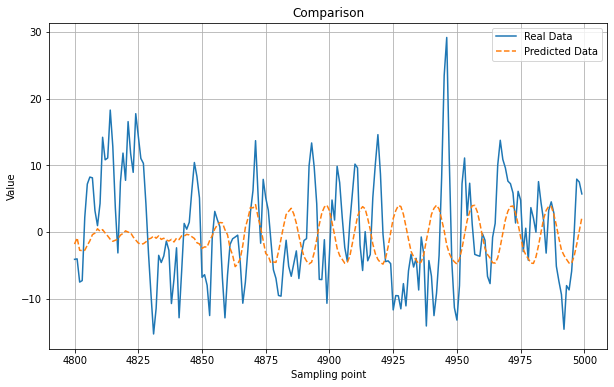

频谱相似度: 0.4010


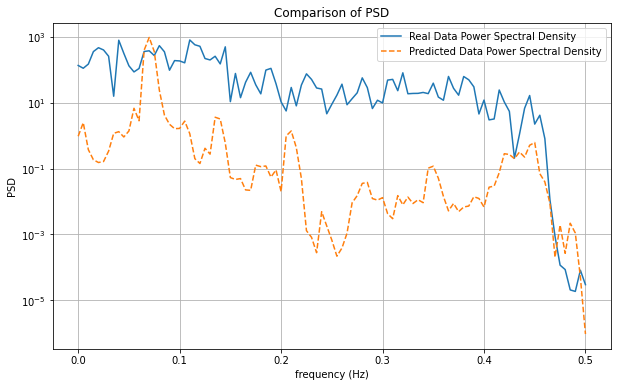

功率谱密度 (PSD) 相似度: 0.2830


In [14]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Input, LSTM
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from scipy.signal import welch
from sklearn.preprocessing import MinMaxScaler

# 固定随机种子
random.seed(23)
np.random.seed(24)
tf.random.set_seed(25)

# 数据归一化
scaler = MinMaxScaler(feature_range=(-1, 1))  
sampled_data = sampled_data[:5000]
train_data = scaler.fit_transform(sampled_data[:4800].reshape(-1, 1)).reshape(-1)
test_data = scaler.transform(sampled_data[4800:].reshape(-1, 1)).reshape(-1)

n_steps = 90  # 时间步长
X, y = [], []

for i in range(len(train_data) - n_steps):
    X.append(train_data[i:i+n_steps])
    y.append(train_data[i+n_steps])

X, y = np.array(X), np.array(y)

# 构建双层 LSTM 模型，不带正则化
def build_lstm_model(input_shape, units):
    inputs = Input(shape=input_shape)
    x = LSTM(units, return_sequences=True)(inputs)  # 第一层 LSTM
    x = LSTM(units)(x)                              # 第二层 LSTM
    x = BatchNormalization()(x)
    x = Dense(64, activation="relu")(x)
    x = Dense(1)(x)
    model = Model(inputs, x)
    return model

# 自定义损失函数结合频谱相似度
def custom_loss(y_true, y_pred):
    mse_loss = K.mean(K.square(y_pred - y_true))
    fft_true = tf.signal.fft(tf.cast(y_true, tf.complex64))
    fft_pred = tf.signal.fft(tf.cast(y_pred, tf.complex64))
    fft_true_abs = tf.abs(fft_true)
    fft_pred_abs = tf.abs(fft_pred)
    spectral_loss = K.mean(K.square(fft_true_abs - fft_pred_abs))
    return mse_loss + 0.05 * spectral_loss  # 减少频谱相似度的权重

# 构建模型
model = build_lstm_model((n_steps, 1), units=128)

# 使用 Nadam 优化器（固定较小的学习率）
optimizer = Nadam(learning_rate=0.0003)

# 编译模型
model.compile(optimizer=optimizer, loss=custom_loss)

# 学习率调度器和早停机制
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6, verbose=1)

# 使用固定的验证集来训练和监控
X_val, y_val = X[:960], y[:960]  # 前 20% 作为验证集
X_train, y_train = X[960:], y[960:]

# 模型训练
epochs = 200
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))  # 调整为 LSTM 输入格式
history = model.fit(
    X_train, y_train, 
    validation_data=(X_val, y_val),
    epochs=epochs, 
    batch_size=32, 
    shuffle=False, 
    verbose=1, 
    callbacks=[early_stopping, lr_scheduler]
)

# 用模型预测未来 200 个点
X_input = train_data[-n_steps:].reshape((1, n_steps, 1))  # 取最后 90 个点作为输入
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)

    # 检查预测值是否异常，避免 NaN 或 inf
    if np.isnan(predicted).any() or np.isinf(predicted).any():
        print(f'Warning: Invalid predicted value at step {_}, setting to 0.')
        predicted[0][0] = 0  # 处理异常值

    predicted_points.append(predicted[0][0])

    # 滑动窗口更新
    predicted_reshaped = np.array(predicted[0][0]).reshape(1, 1, 1)
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)

predicted_points = np.array(predicted_points)  # 将预测结果转换为 NumPy 数组

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_data.reshape(-1, 1)).reshape(-1)

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制预测结果与真实数据的对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data_rescaled, label='Real Data')
plt.plot(range(4800, 5000), predicted_points_rescaled, label='Predicted Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)

fft_real_abs = np.abs(fft_real).reshape(1, -1)
fft_pred_abs = np.abs(fft_pred).reshape(1, -1)
spectral_similarity = cosine_similarity(fft_real_abs, fft_pred_abs)[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD)
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)  # Welch 方法计算真实数据的功率谱密度
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)  # 计算预测数据的功率谱密度

plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real Data Power Spectral Density')
plt.semilogy(f_pred, psd_pred, label='Predicted Data Power Spectral Density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算频域特征匹配度 (余弦相似度)
psd_real = psd_real.reshape(1, -1)
psd_pred = psd_pred.reshape(1, -1)
psd_similarity = cosine_similarity(psd_real, psd_pred)[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')
